\


This is more advanced notebook on how use `easyXRD`. We explain more keywords on loading and refining.\
See the next notebook `03_advanced.ipynb` for more advanced features once you successfully run all cells in this notebook.

\

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/MehmetTopsakal/easyXRD/blob/main/examples/02_intermediate.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in this notebook on Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/MehmetTopsakal/easyXRD/blob/main/examples/02_intermediate.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

\

In order to run this notebook on Google Colab (https://colab.research.google.com/), we need:

* `easyXRD` [package](https://github.com/MehmetTopsakal/easyXRD) from GitHub,
* `GSAS-II` [package](https://github.com/AdvancedPhotonSource/GSAS-II) from GitHub,



By executing the next cell (`Shift + Enter`) , we do all these necessary steps above. Note that everything runs on Google Colab!

In [1]:
# This clones easyXRD repo from GitHub
!! git clone https://github.com/MehmetTopsakal/easyXRD.git

# This copies LaB6_synchrotron_XRD_from_28ID-2.xy file from easyXRD/examples/data into working directory of this notebook
!! cp easyXRD/examples/data/LaB6/LaB6_synchrotron_XRD_from_28ID-2.xy .
# This copies LaB6_structure_from_MaterialsProject.cif file from easyXRD/examples/data into working directory of this notebook
!! cp easyXRD/examples/data/LaB6/LaB6_structure_from_MaterialsProject.cif .

# This clones GSAS-II repo from GitHub
!! git clone https://github.com/AdvancedPhotonSource/GSAS-II
# In order to make GSAS-II run on Google Colab, we need to copy some binary files from GSAS-II-buildtools repo. Following lines do these for us.
!! mkdir GSAS-II/GSASII-bin GSAS-II/GSASII-bin/linux_64_p3.11_n1.26
!! curl -s -L https://github.com/AdvancedPhotonSource/GSAS-II-buildtools/releases/download/v1.0.1/linux_64_p3.11_n1.26.tgz | tar zxvf - -C GSAS-II/GSASII-bin/linux_64_p3.11_n1.26
!! mkdir ~/g2full
!! mv GSAS-II ~/g2full

# Although Google Colab environment has many packages pre-installed, we need a few more python packages to be installed.
# Lines below do all the nexessary installs for us
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install numpy==1.26.4
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install pyFAI==2024.9.0
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install fabio==2024.9.0
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install pybaselines
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install pymatgen
!! UV_CONSTRAINT= UV_BUILD_CONSTRAINT= uv pip install mp_api

# Finally, we nedd to reset kernel for the new package installations to take effect
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

!! echo done

['done']

In [2]:
# # This copies contents of `easyXRD/examples/data` to working diractory of this notebook,
!! cp -r easyXRD/examples/data/* .

!! echo done

['done']

In [3]:
import sys
sys.path += ["easyXRD"] # Adding easyXRD python package that we cloned from GitHub into sys
from easyxrd.core import exrd # import exrd class

# importing matplotlib for plots with interactive support.
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.constrained_layout.use"] = True # For better plots.

# Enabling custom widget for "%matplotlib widget" line above to work in Colab
from google.colab import output
output.enable_custom_widget_manager()

import os
import fabio

# You will also need Materials Project api key.
# You can get if from here: https://next-gen.materialsproject.org/api#api-key
api_key = 'dHgNQRNYSpuizBPZYYab75iJNMJYCklB'



Checking required packages:

---pyFAI package with version 2024.9.0 is available and can be imported 
---pybaselines package with version 1.2.0 is available and can be imported 
---numpy package with version 1.26.4 is available and can be imported 
---scipy package with version 1.14.1 is available and can be imported 
---pymatgen package with version 2025.3.10 is available and can be imported 
---xarray package with version 2025.1.2 is available and can be imported 
---pandas package with version 2.2.2 is available and can be imported 
---mp_api package with version 0.45.3 is available and can be imported 
---fabio package with version 2024.9.0 is available and can be imported 


Imported easyxrd with the following configuration:

easyxrd_scratch_path : /root/.easyxrd_scratch
gsasii_lib_path : /root/g2full/GSAS-II/GSASII
mp_api_key : none......


In [4]:
# We can list the contents of currant working directory with listdir command
os.listdir()

['.config',
 'CeO2',
 'Kapton',
 'easyXRD',
 'geometry.poni',
 'LaB6_synchrotron_XRD_from_28ID-2.xy',
 'mask.edf',
 'LaB6_CeO2_mix',
 'LaB6_structure_from_MaterialsProject.cif',
 'LaB6',
 'sample_data']

# LaB6

Here we start with LaB6/img.tiff which is actually 2D raw image of `LaB6_synchrotron_XRD_from_28ID-2.xy` file we used in previous notebook.

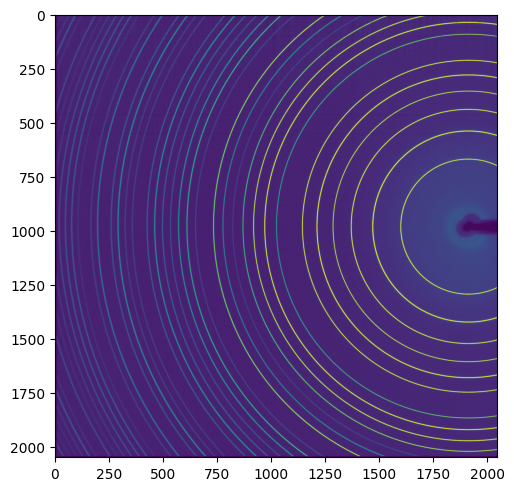

In [5]:
# We can display the LaB6/img.tiff as below.
plt.figure()
plt.imshow(fabio.open('LaB6/img.tiff').data,vmin=0,vmax=100)

In order to radially integrate this 2D image, we need to use [pyFAI](https://pyfai.readthedocs.io/en/stable/).

Please refer to resources below about pyFAI usage.

* https://www.youtube.com/watch?v=hqp0UyvepXk&ab_channel=ESRFsynchrotron
* https://github.com/MehmetTopsakal/pySULI/blob/main/notebooks/003_learn_pyFAI.ipynb


We have provided a poni file `geometry.poni` in the working directory. It is basically a text file with the information below. Please refer to  pyFAI documentation about the meaning of poni file.

<ul>
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis<br>
# Calibration done at Mon Apr  8 17:18:53 2024<br>
poni_version: 2.1<br>
Detector: Perkin\
Detector_config: {"pixel1": 0.0002, "pixel2": 0.0002, "orientation": 3}<br>
Distance: 1.4280248574010523<br>
Poni1: 0.23404917788488025<br>
Poni2: 0.3766844373109601<br>
Rot1: -0.0037624252170773112<br>
Rot2: -0.026178177480714798<br>
Rot3: -7.996604624242792e-10<br>
Wavelength: 1.814e-11<br>
</ul>

In the 2D image above, there are some areas such as beamstop shadow, bad pixels and the edges of the detector that we need to mask. You can use `pyFAI-drawmask` executable that comes with pyFAI package. See https://pyfai.readthedocs.io/en/v2023.1/man/pyFAI-drawmask.html We have provided a mask file as displayed below.

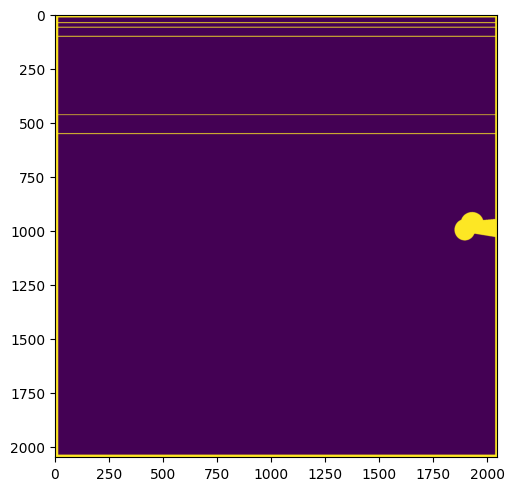

In [6]:
plt.figure()
plt.imshow(fabio.open('mask.edf').data)

In [7]:
# We believe, we made it quite straightforward to read and integrate a given 2D detector tiff file using easyXRD.

# As usual, we need to initialize exrd object.
sample = exrd()

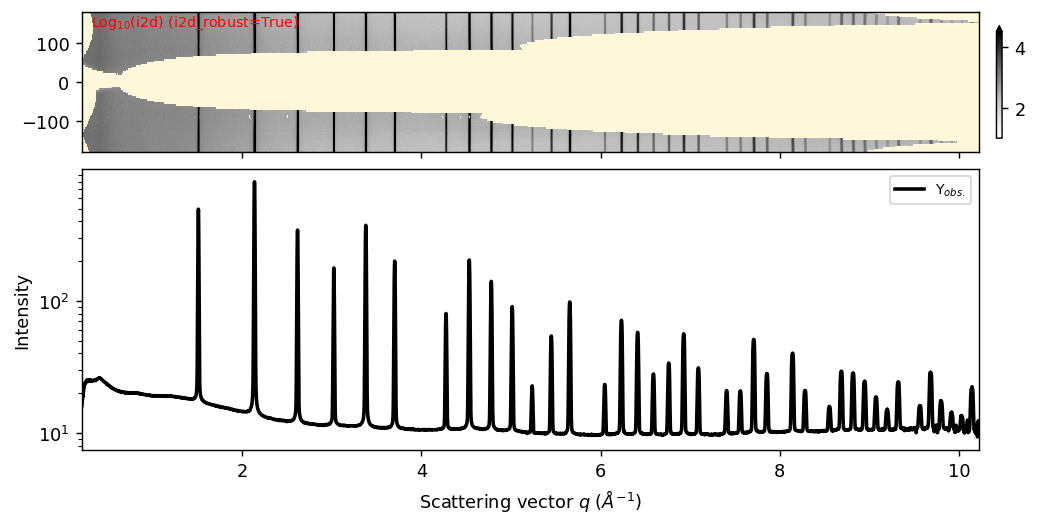

In [8]:
sample.load_xrd_data(
    from_tiff_file='LaB6/img.tiff', # image file
    poni_file='geometry.poni', # poni file you can get from pyFAI-calib2.
    mask_file='mask.edf', # maks file you can get from pyFAI-drawmask.
    )

# The bottom subplot in the figure below is same as 1D profile we loaded in previous notebook, 01_basic.ipynb.
# The new information is 2D image (i2d) in the upper subplot. It is basically reorganized data of LaB6/img.tiff
# we plotted in the first figure above. XRD community calls it as "cake". The yellow-ish parts are masked regions.
# If we average this image in y-direction, we get the 1D profile that we call as "i1d".

/root/g2full/GSAS-II/GSASII

 ⏩--1st refinement with LeBail is completed. Rwp/GoF is 28.828/1.207 

 ✅--Background with 10 coeffs is refined. Rwp/GoF is now 14.957/0.627 (was 28.828(-48.12%)/1.207(-48.09%✨))
 ✅--Cell parameters are refined. Rwp/GoF is now 11.001/0.461 (was 14.957(-26.45%)/0.627(-26.48%✨))
 ✅--Instrument parameter ['U'] is refined. Rwp/GoF is now 8.275/0.347 (was 11.001(-24.78%)/0.461(-24.78%✨))
 ✅--Instrument parameter ['V'] is refined. Rwp/GoF is now 7.968/0.334 (was 8.275(-3.71%)/0.347(-3.71%))
 ✅--Instrument parameter ['W'] is refined. Rwp/GoF is now 7.787/0.326 (was 7.968(-2.27%)/0.334(-2.27%))
 ✅--Instrument parameter ['Zero'] is refined. Rwp/GoF is now 7.726/0.324 (was 7.787(-0.77%)/0.326(-0.77%❗))
 ✅--Cell parameters are refined. Rwp/GoF is now 7.723/0.323 (was 7.726(-0.05%)/0.324(-0.05%❗))
 ✅--Background with 15 coeffs is refined. Rwp/GoF is now 7.515/0.315 (was 7.723(-2.69%)/0.323(-2.62%))


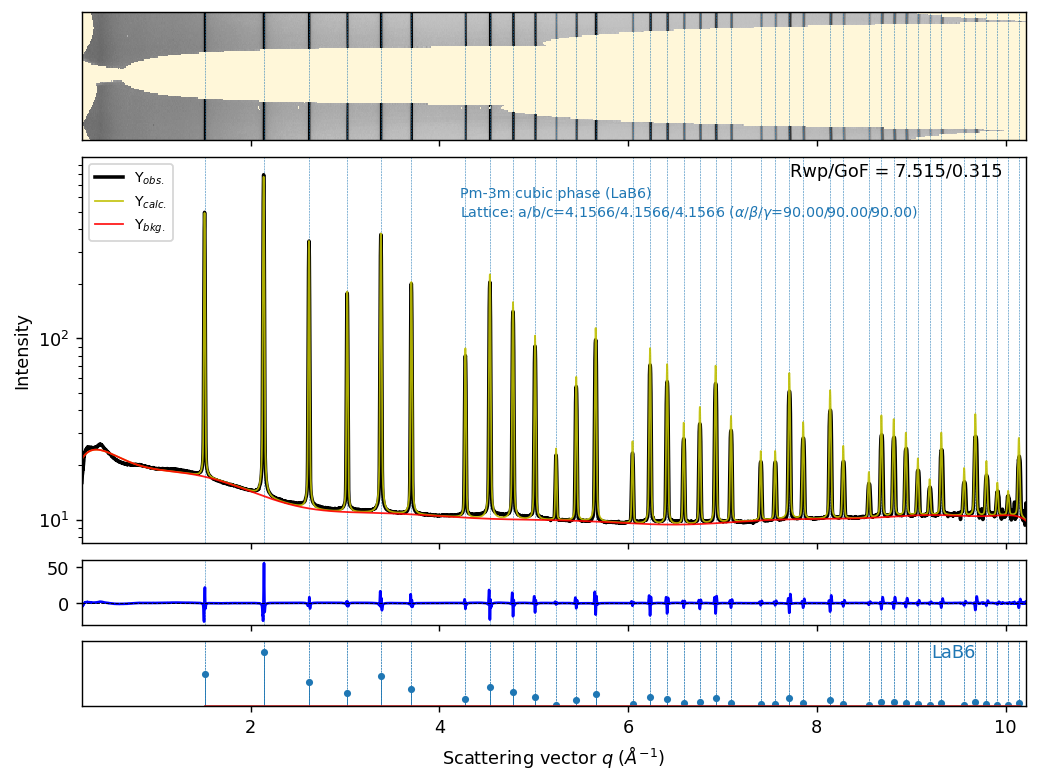

In [9]:
# Now we can refine this sample information using easyXRD as we did in previous notebook.

sample.load_phases(
    [{"cif": "LaB6/LaB6_structure_from_MaterialsProject.cif", "label": "LaB6"}], plot=False
)
sample.setup_gsas2_refiner(plot=False)

sample.refine_background(plot=False)
sample.refine_cell_parameters(plot=False)
sample.refine_instrument_parameters(inst_pars_to_refine=["U"], plot=False)
sample.refine_instrument_parameters(inst_pars_to_refine=["V"], plot=False)
sample.refine_instrument_parameters(inst_pars_to_refine=["W"], plot=False)
sample.refine_instrument_parameters(inst_pars_to_refine=["Zero"], plot=False)

# We can re-refine background since we improved instrument parameters in previous steps
sample.refine_cell_parameters(plot=False)

# We can re-refine background with higher number of coefficients
sample.refine_background(num_coeffs=15, plot=False)

sample.plot()

If you zoom in to high-q regions in the above plot you will see that the Yobs. is getting noisy. The reason is clear \
in the 12d information. Because, those regions correspponds to the edge of the detector and less pixels contribute to \
the data making the i1d plot noisy. Therefore, we can exlude those regions and the low q areas corresponding to beam-stop \
with the `radial_range=[1, 9.5]` keyword as we did in previous notebook `01_basic.ipynb`. We believe, this is a strength \
of `easyXRD`. We can see the raw data alongside 1d profile. To the best of our knowledge, no other programs such as
`TOPAS, GSAS-II or FullProf...` has this functionality.

In [10]:
# Now we can export refined as LaB6 GSAS-II project file (gpx).
sample.export_gpx_to('LaB6.gpx')

# CeO2

Now we can continue with `CeO2` NIST powder (https://tsapps.nist.gov/srmext/certificates/674b.pdf ) XRD data which was collected in same beamline conditions.


In [11]:
# As usual, we need to initialize exrd object.
sample = exrd()

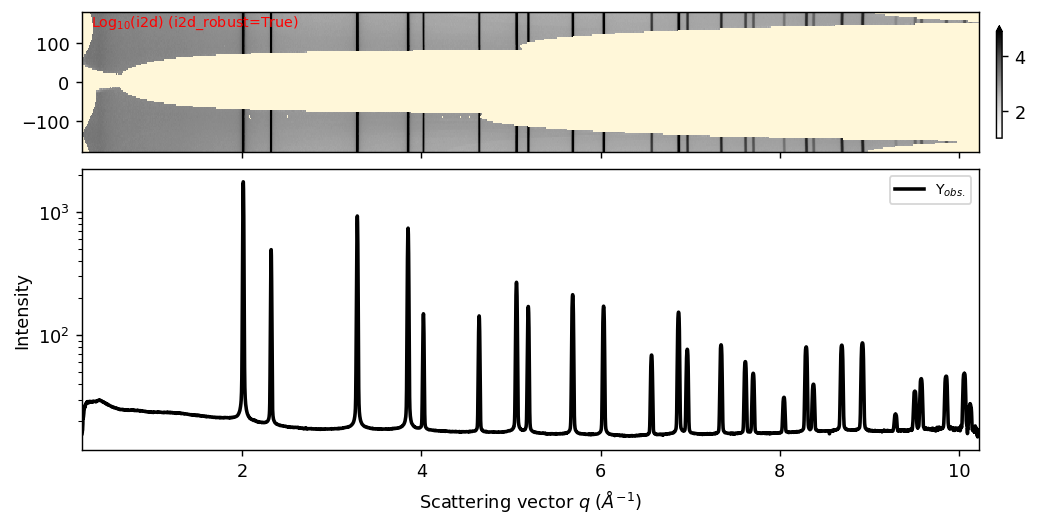

In [12]:
sample.load_xrd_data(
    from_tiff_file='CeO2/img.tiff', # image file
    poni_file='geometry.poni', # poni file you can get from pyFAI-calib2.
    mask_file='mask.edf', # maks file you can get from pyFAI-drawmask.
    )

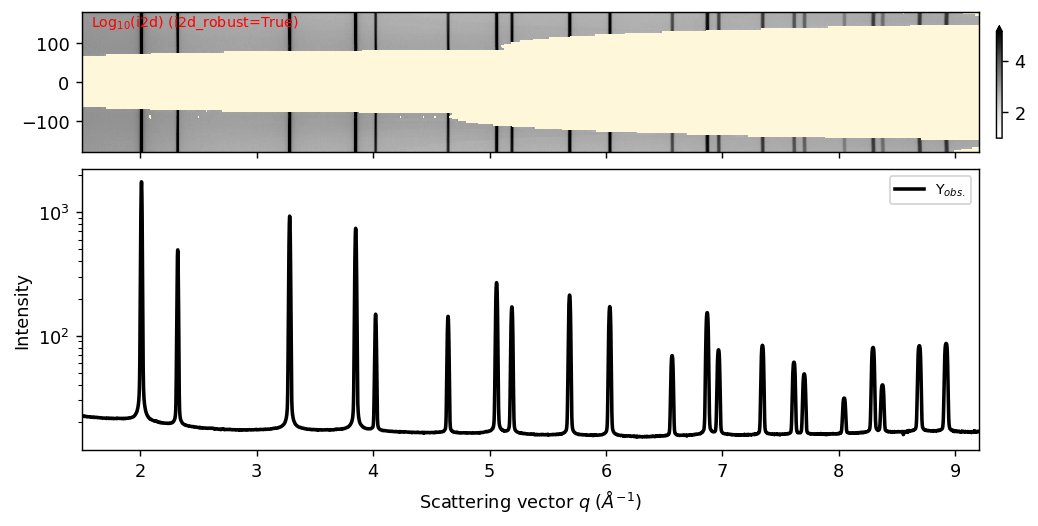

In [13]:
# Based on plot above, it would be good to limit q_range from 1.5 to 9.2

sample.load_xrd_data(
    from_tiff_file='CeO2/img.tiff', # image file
    poni_file='geometry.poni', # poni file you can get from pyFAI-calib2.
    mask_file='mask.edf', # maks file you can get from pyFAI-drawmask.
    radial_range=[1.5, 9.2]
    )

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

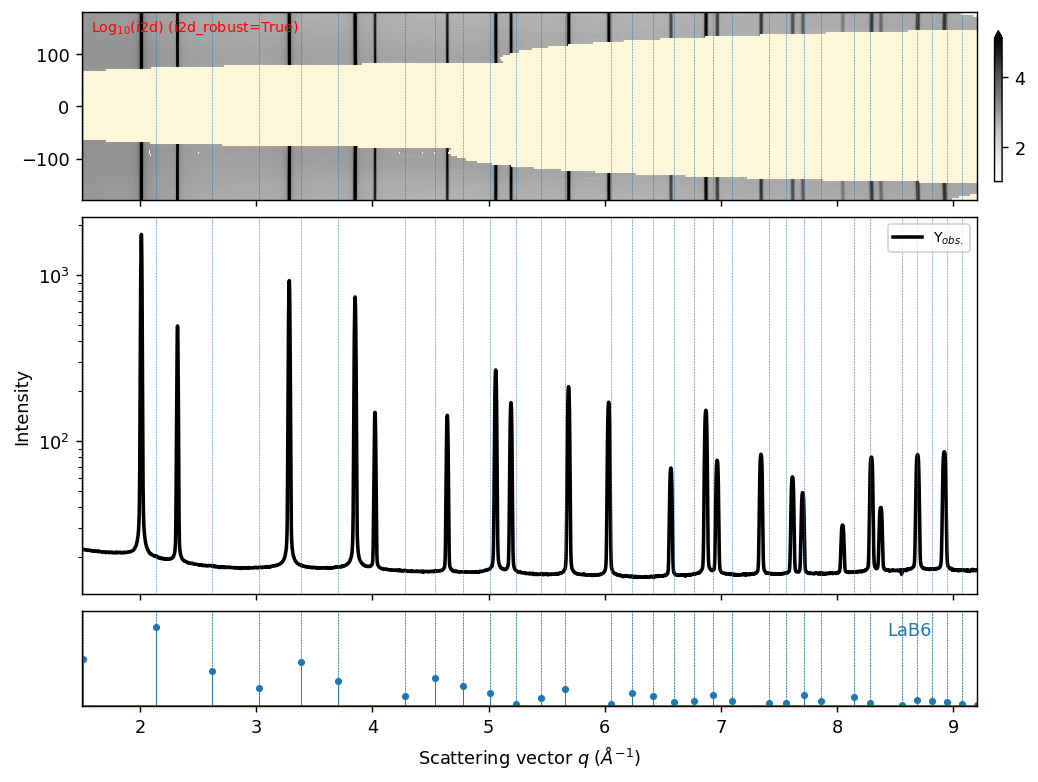

In [14]:
# Lets try LaB6 Materials Project id (mp-2680) in this CeO2 XRD.

sample.load_phases(
    [{"mp_id": "mp-2680", "label": "LaB6"}],
    plot=True,
    mp_rester_api_key=api_key,
    )

# Obviously, it doesn't match CeO2 loaded here.

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

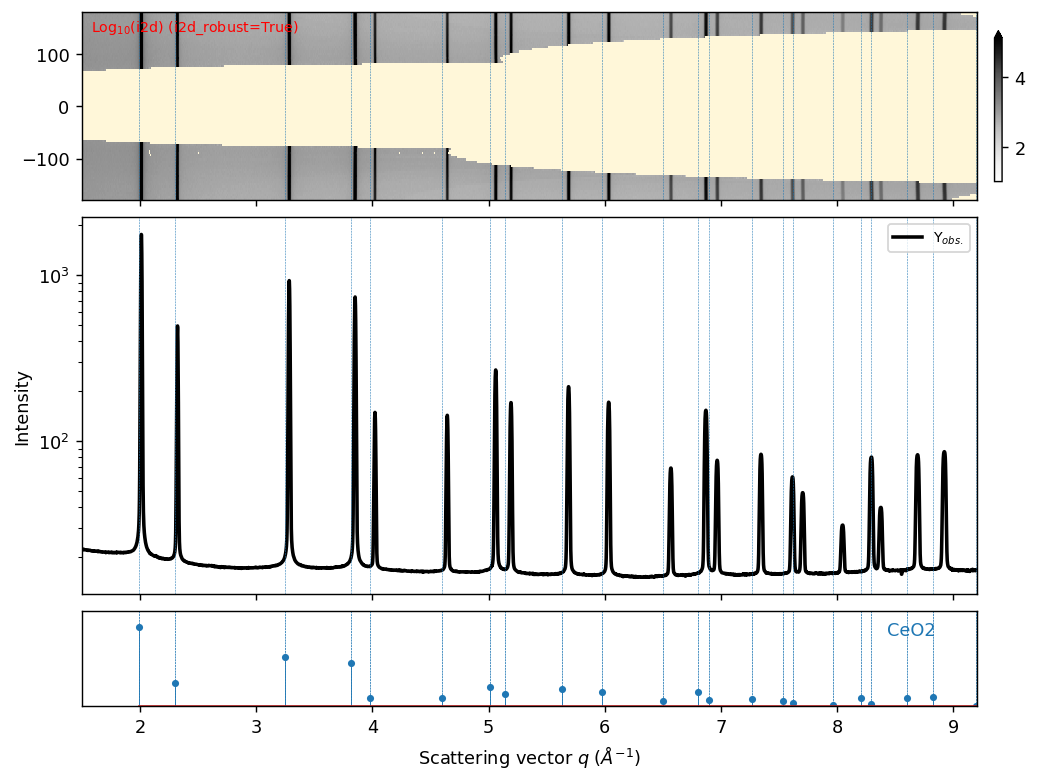

In [16]:
# The correct structure id should be mp-20194 for CeO2.pdf.
# https://legacy.materialsproject.org/materials/mp-20194/

sample.load_phases(
    [{"mp_id": "mp-20194", "label": "CeO2"}],
    plot=True,
    mp_rester_api_key=api_key,
    )

# This sturucture works for the Yobs. for small q values. But it gets worse for high q-values.
# This is a result of wrongly calculated lattice constant of CeO2 on Materials Project.
# Before correcting the value, let's see whether the XRD refinement will get the correct lattice.

/root/g2full/GSAS-II/GSASII

 ⏩--1st refinement with LeBail is completed. Rwp/GoF is 61.155/0.779 



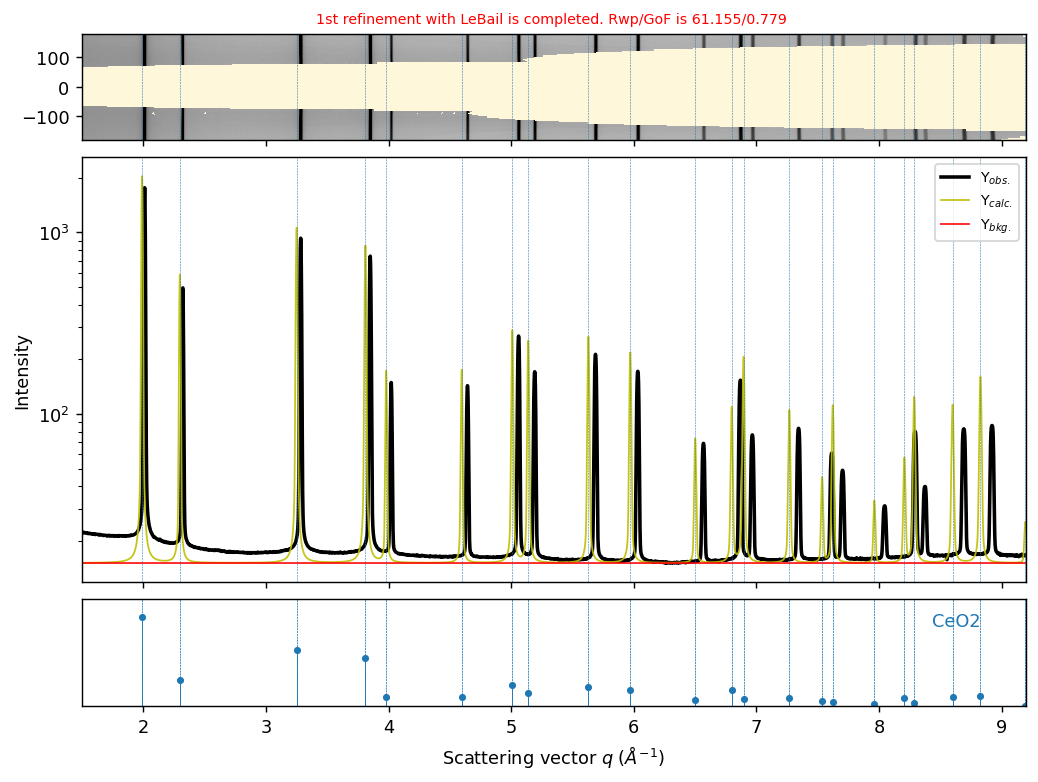

In [17]:
# Here we proceed with refinement.
# Since we refined the instrument parameters previously on LaB6, ideally we shouldn't refine it for CeO2.
# We can use instprm_from_gpx keyword in setup_gsas2_refiner to use refined instrument parameters.

sample.setup_gsas2_refiner(plot=True, normalize=True, instprm_from_gpx='LaB6.gpx')

# As a result, refinement is very poor. Because of the lattice.

 ✅--Cell parameters are refined. Rwp/GoF is now 61.119/0.779 (was 61.155(-0.06%)/0.779(-0.05%❗))


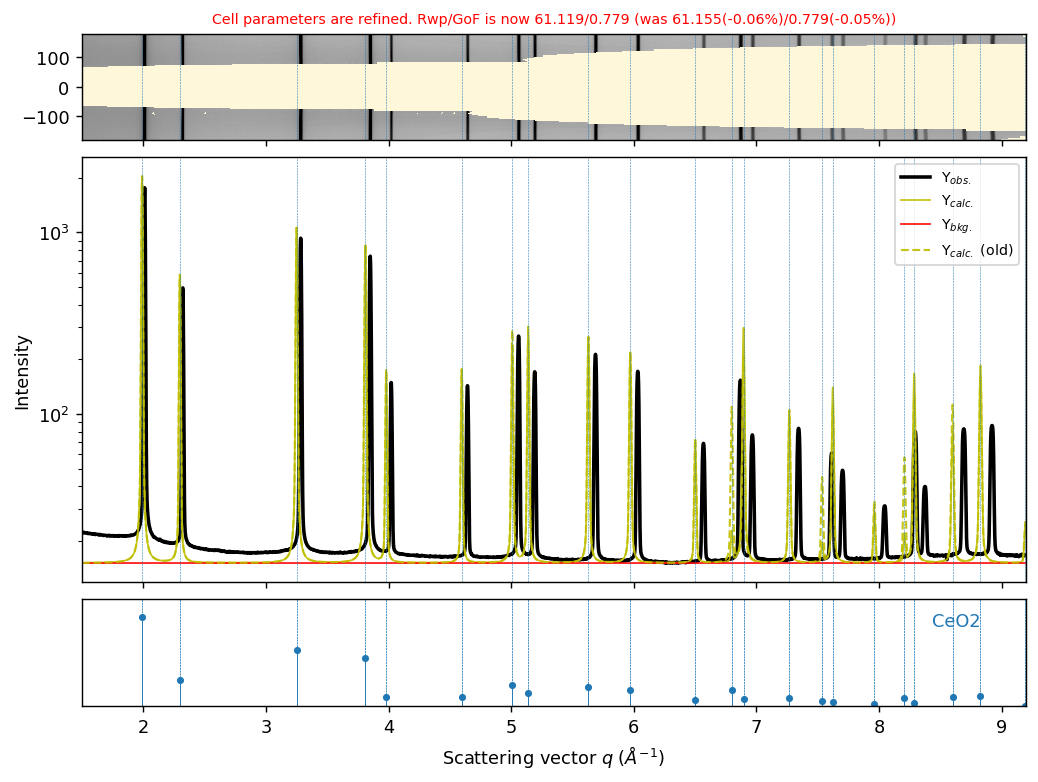

In [18]:
# Let's refine the cell parameters.

sample.refine_cell_parameters(plot=True)

# Obviously, the cell refinement was not able to find correct lattice, hence it is still a poor fit.

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

/root/g2full/GSAS-II/GSASII

 ⏩--1st refinement with LeBail is completed. Rwp/GoF is now 15.052/0.192 (was 61.155(-75.39%)/0.779(-75.39%✨)) 

 ✅--Cell parameters are refined. Rwp/GoF is now 12.780/0.163 (was 15.052(-15.09%)/0.192(-15.08%✨))


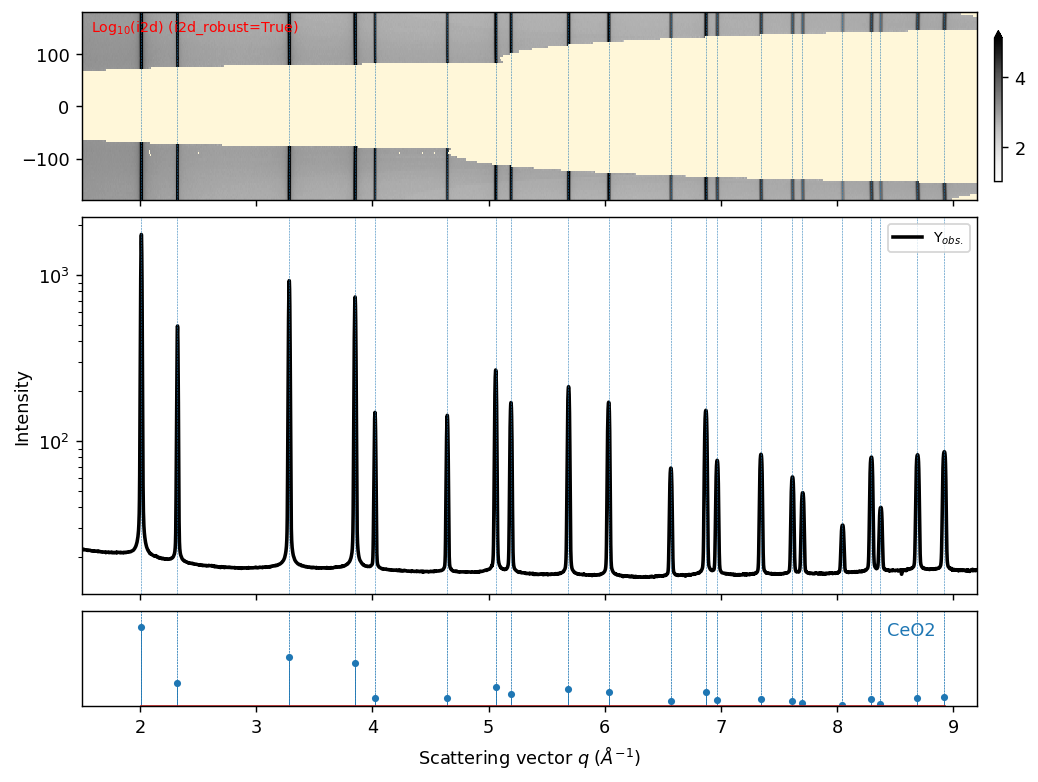

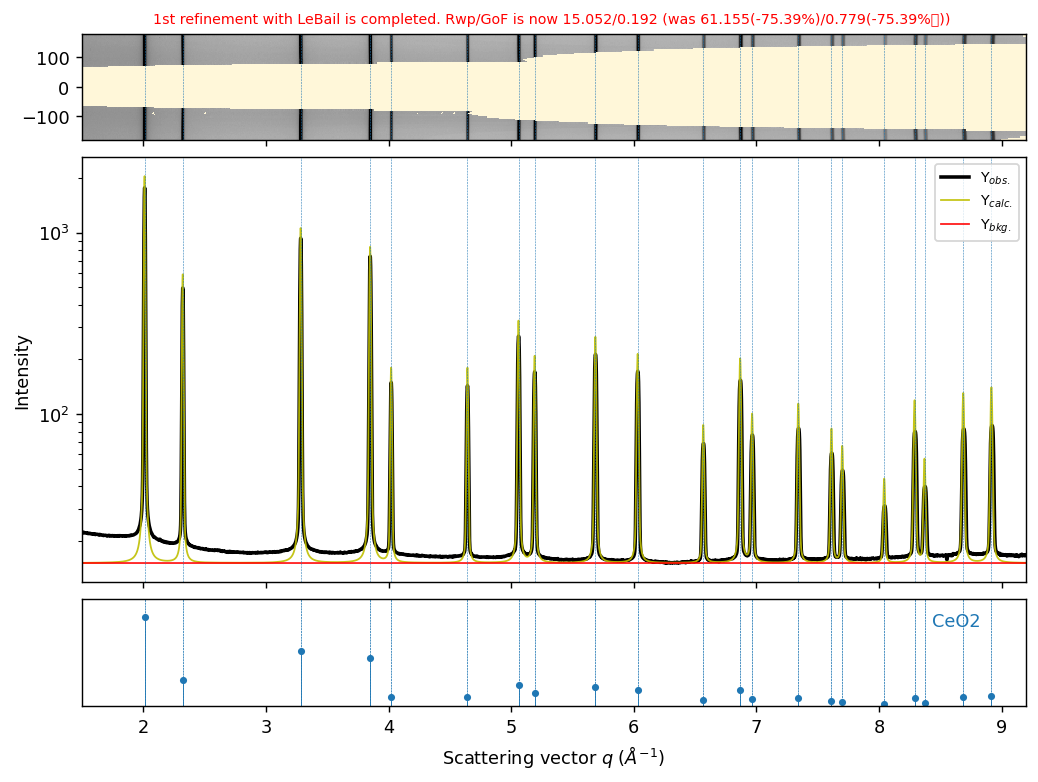

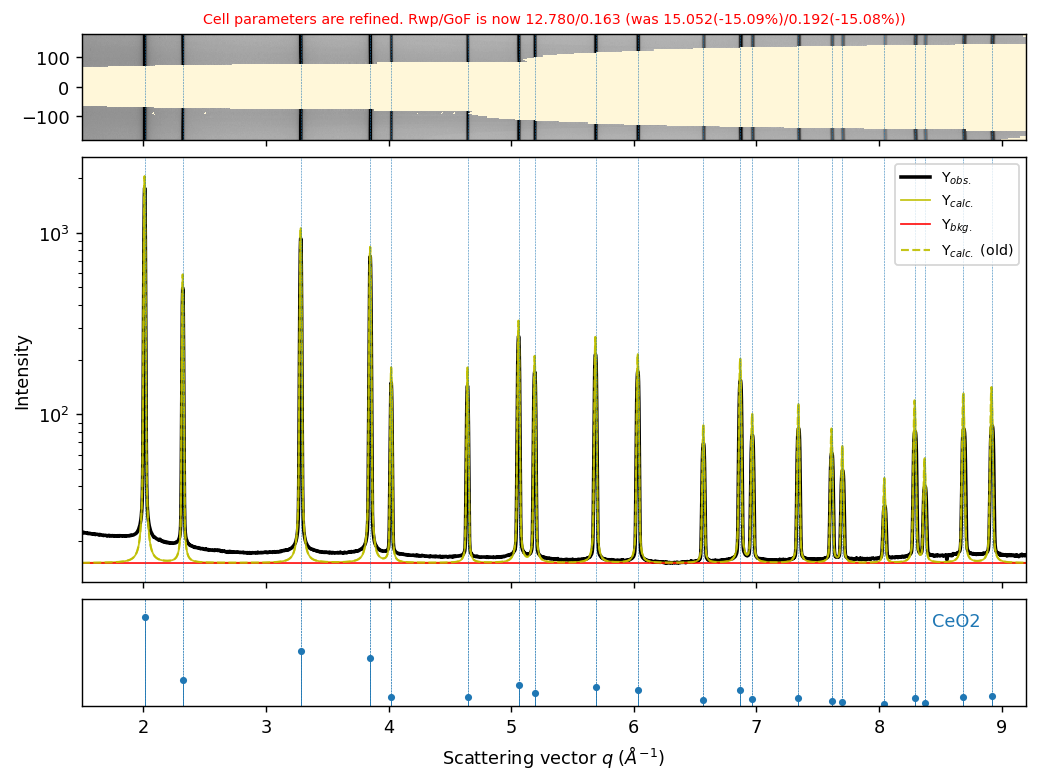

In [19]:
# Therefore, we can "help" refinement by manually changing the lattice parameters.
# For this, we need to use "scale" parameter in phases dict.

sample.load_phases(
    [{"mp_id": "mp-20194", "label": "CeO2", "scale": 0.99}],
    plot=True,
    mp_rester_api_key=api_key,
    )


sample.setup_gsas2_refiner(plot=True, normalize=True, instprm_from_gpx='LaB6.gpx')
sample.refine_cell_parameters(plot=True)

 ✅--Background with 5 coeffs is refined. Rwp/GoF is now 9.131/0.116 (was 12.780(-28.55%)/0.163(-28.54%✨))
 ✅--Background with 10 coeffs is refined. Rwp/GoF is now 8.969/0.114 (was 9.131(-1.77%)/0.116(-1.74%))
 ✅--Background with 15 coeffs is refined. Rwp/GoF is now 8.941/0.114 (was 8.969(-0.31%)/0.114(-0.28%❗))


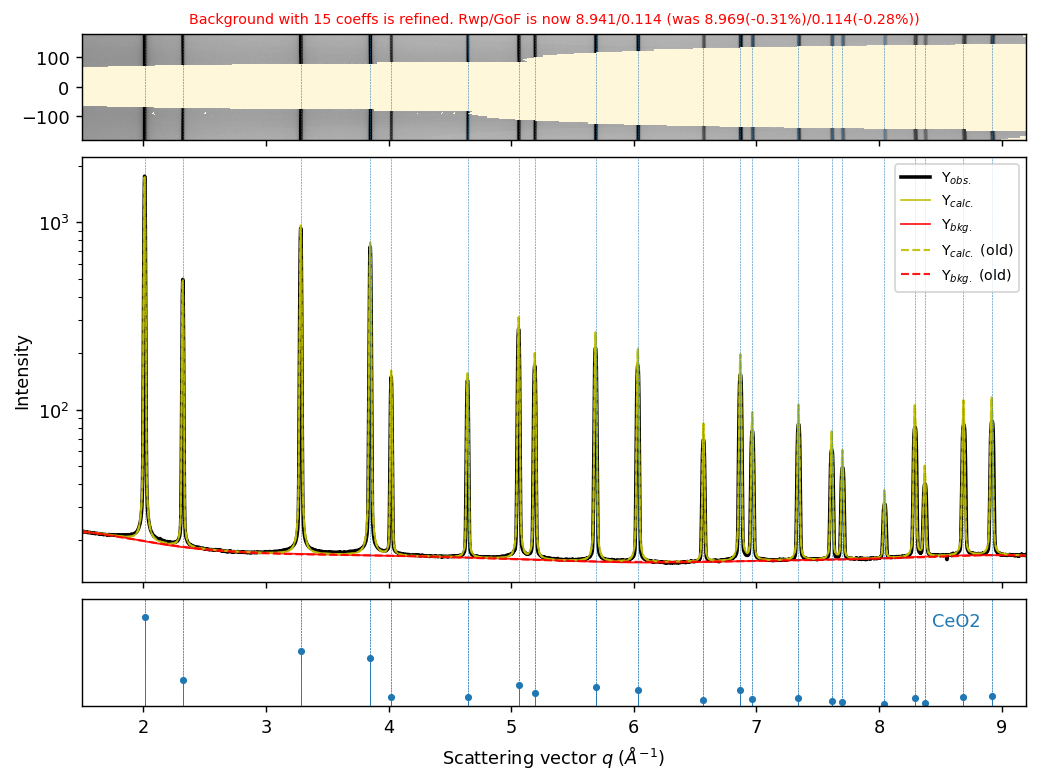

In [20]:
# Here we refine the background by gradually increasing the number of coefficients.

sample.refine_background(num_coeffs=5,plot=False)
sample.refine_background(num_coeffs=10,plot=False)
sample.refine_background(num_coeffs=15,plot=True)

 ✅--Size broadening of all phases are refined. Rwp/GoF is now 8.946/0.114 (was 8.941(0.05%)/0.114(-0.04%❗))


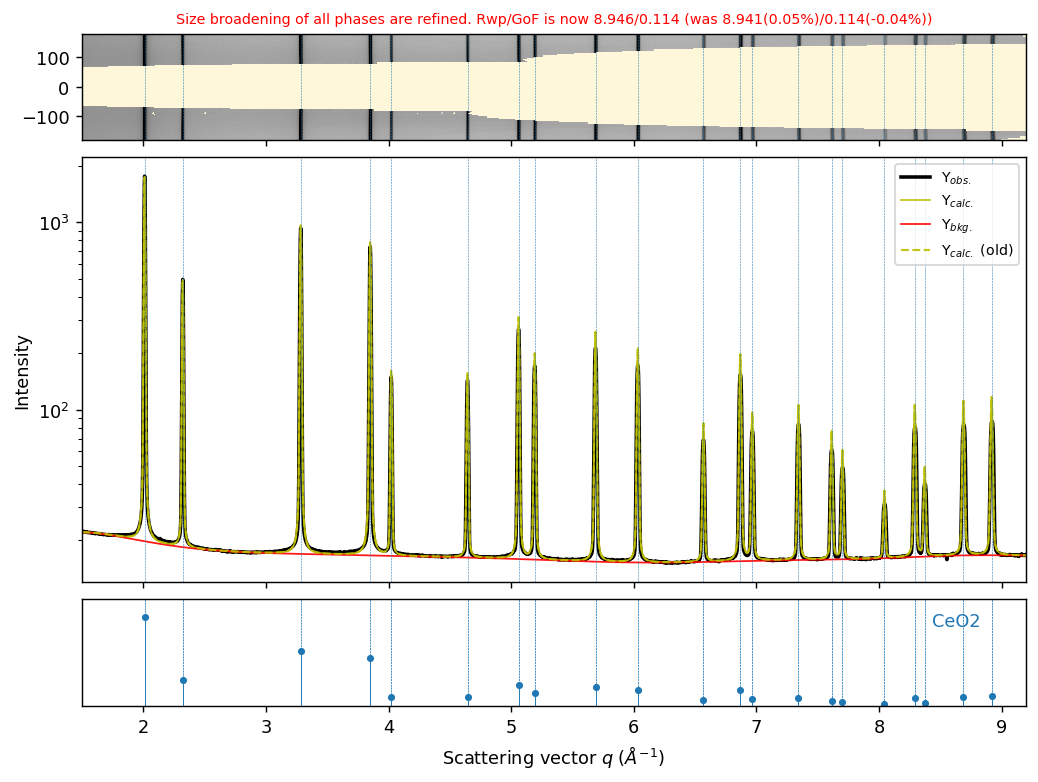

In [21]:
# Here we refine size broadening.

sample.refine_size_broadening(plot=True)

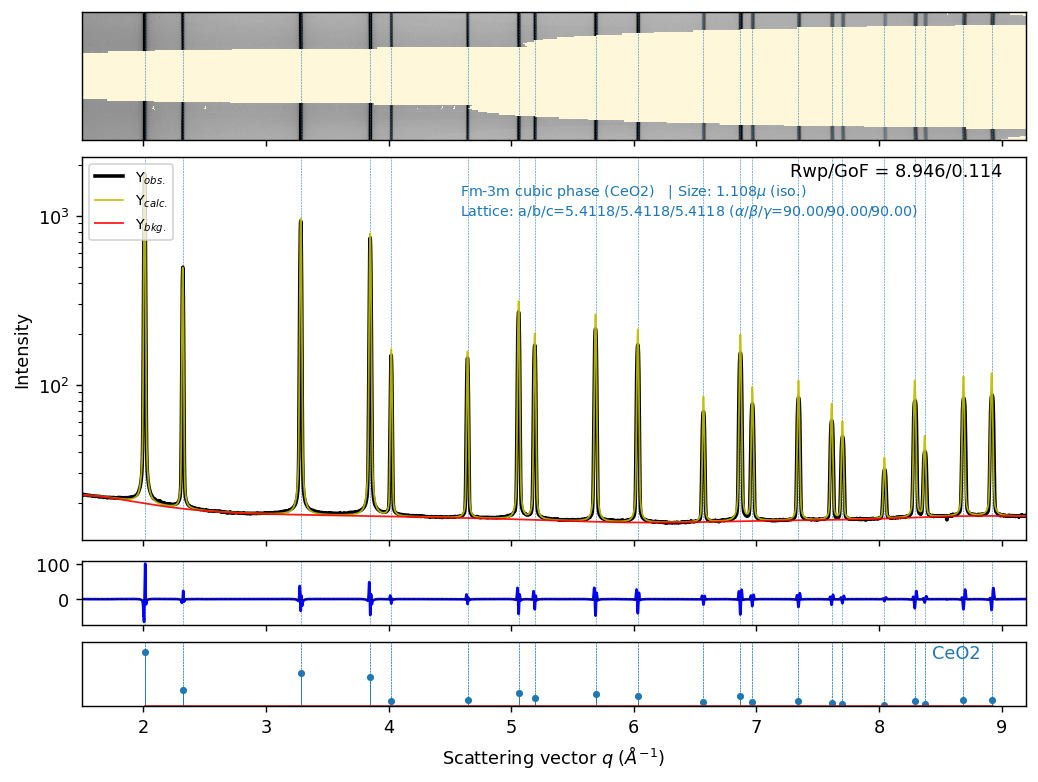

In [22]:
# This creates a final figure with LeBail refinement.

sample.plot()


 ✅--After setting LeBail refinement to True, Rwp/GoF is now 10.867/0.138 (was 8.946(21.48%)/0.114(21.47%❗))


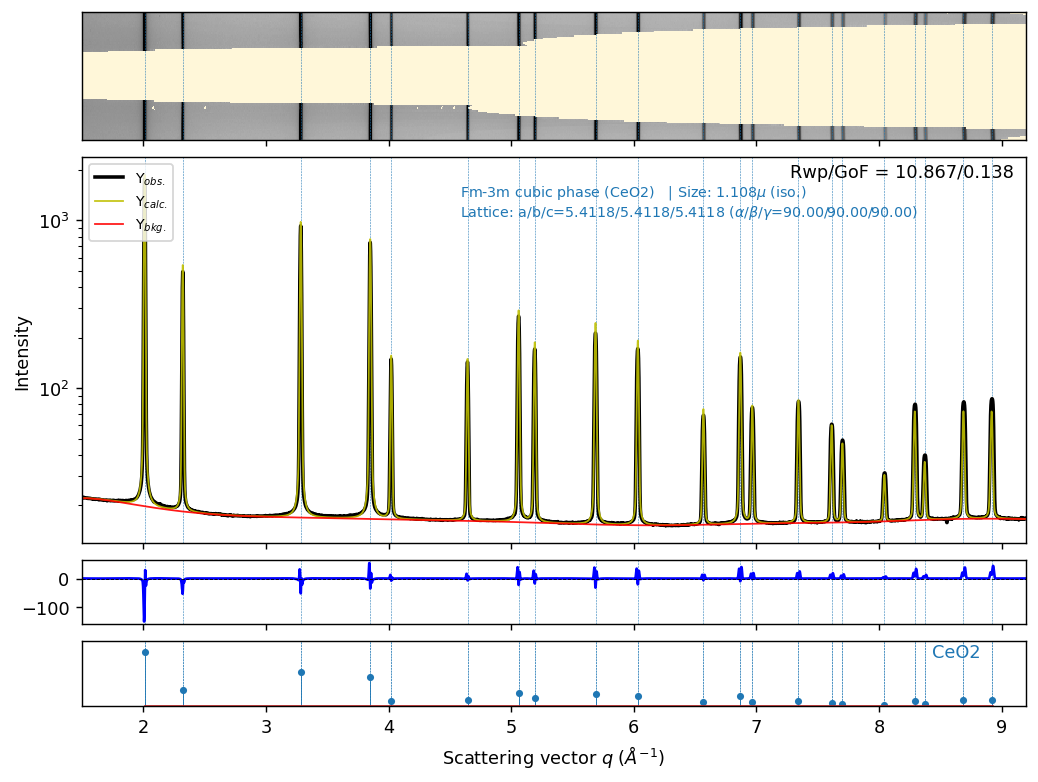

In [23]:
# Until now, we were doing Le-Bail refinements in which atom positions are not taken into consideration.
# We enable Rietveld by setting LeBail to false in GSAS settings.

sample.set_LeBail(to=False, refine=True, plot=False)
sample.plot()

# If you zoom in figure below, you will see the peak intensites got worse especially at high-q regions.

As next step, we can refine atom properties. Below is the screenshot of the GSAS-II window of this sample.

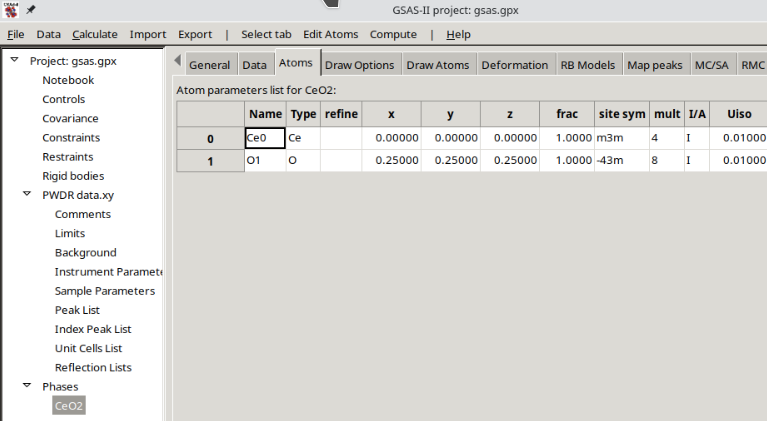

There is not much to refine in atomic positions. But we can refine the U parameters of Ce and O sites as shown in next cell.

 ✅--U property of Ce0 site of CeO2 phase is refined. Rwp/GoF is now 8.887/0.113 (was 10.867(-18.23%)/0.138(-18.22%✨))
 ✅--U property of O1 site of CeO2 phase is refined. Rwp/GoF is now 8.851/0.113 (was 8.887(-0.41%)/0.113(-0.41%❗))


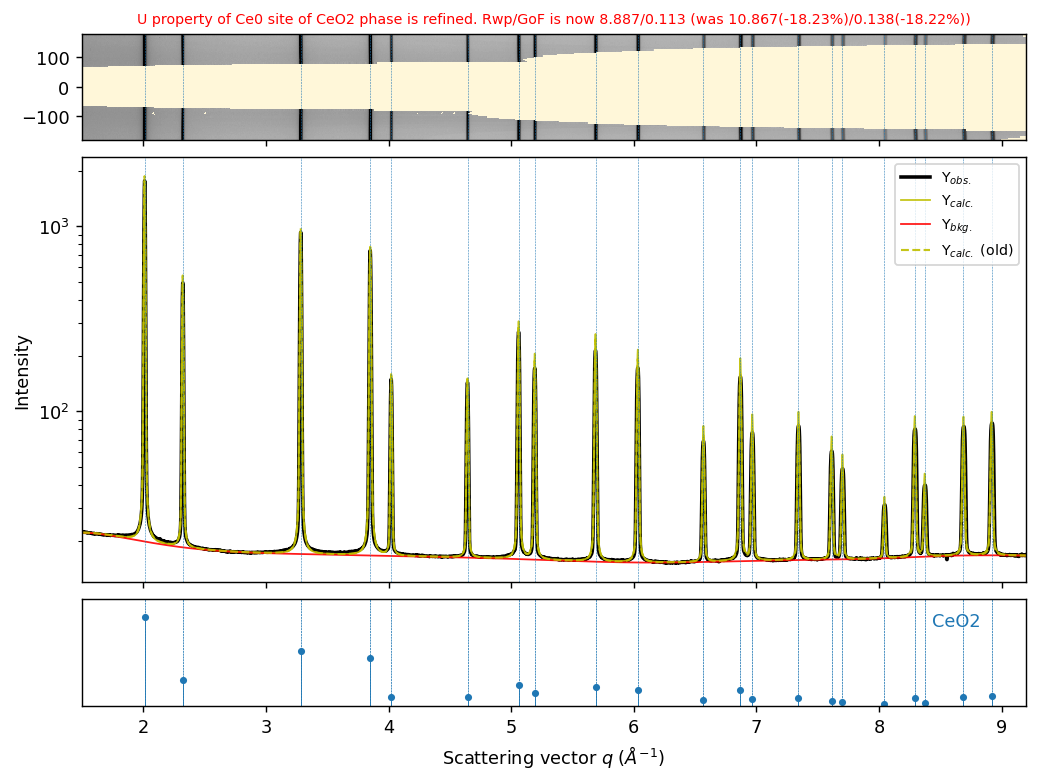

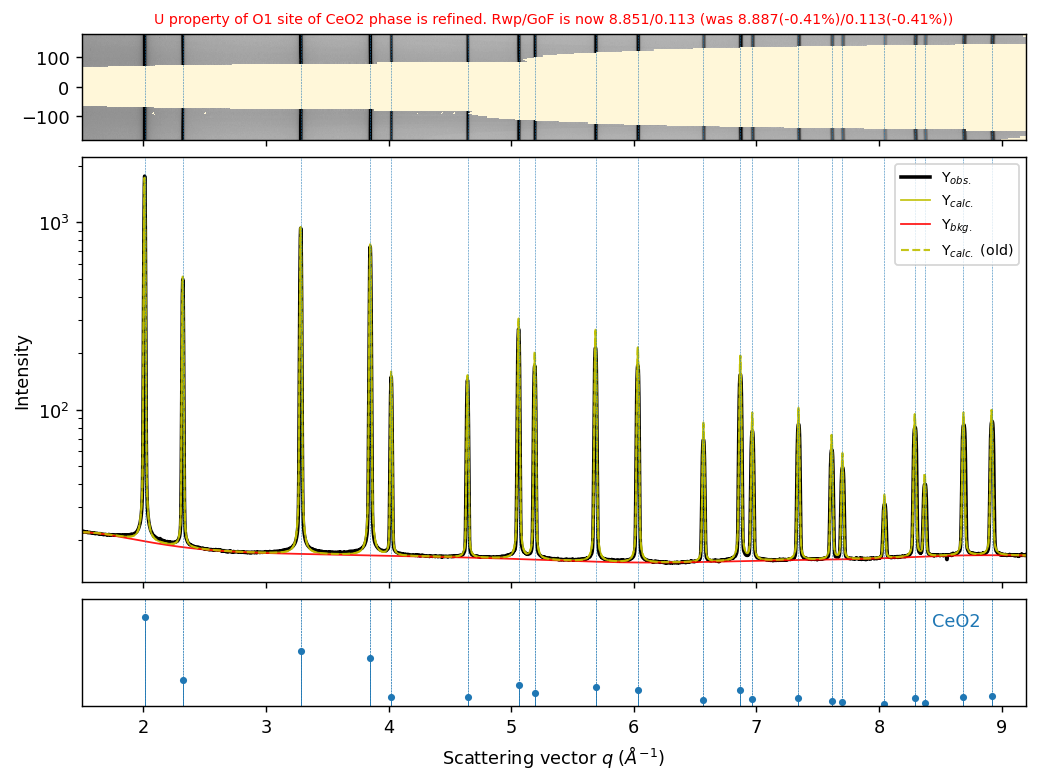

In [24]:
sample.refine_site_property(site_ind=0,refinement_flags='U',plot=True) # This refines Uiso of Ce site
sample.refine_site_property(site_ind=1,refinement_flags='U',plot=True) # This refines Uiso of O site

# Note the improvement at high q values and Rwp/GoF, especially for Ce site.

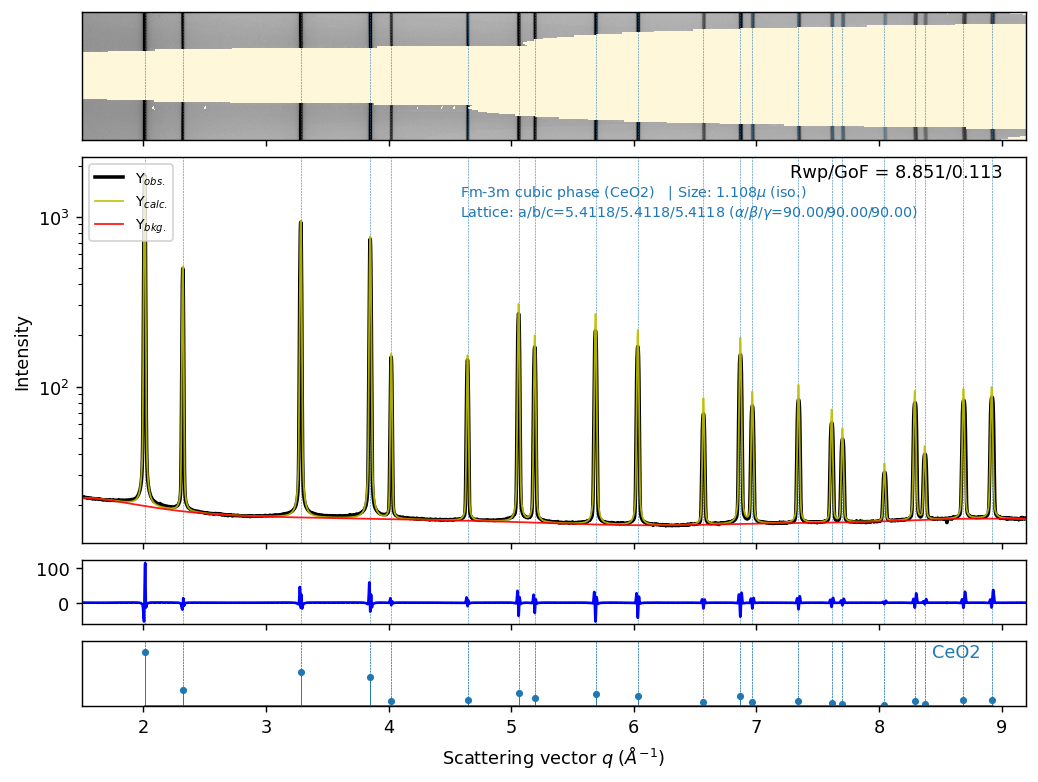

In [25]:
# This is the final plot

sample.plot()

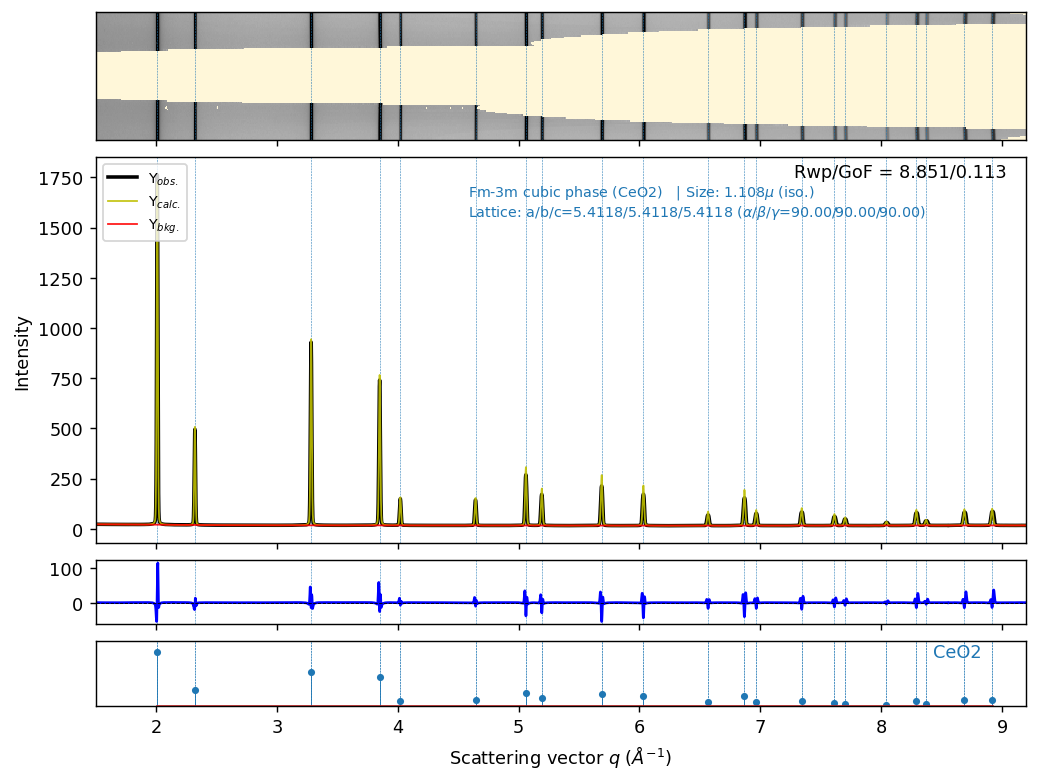

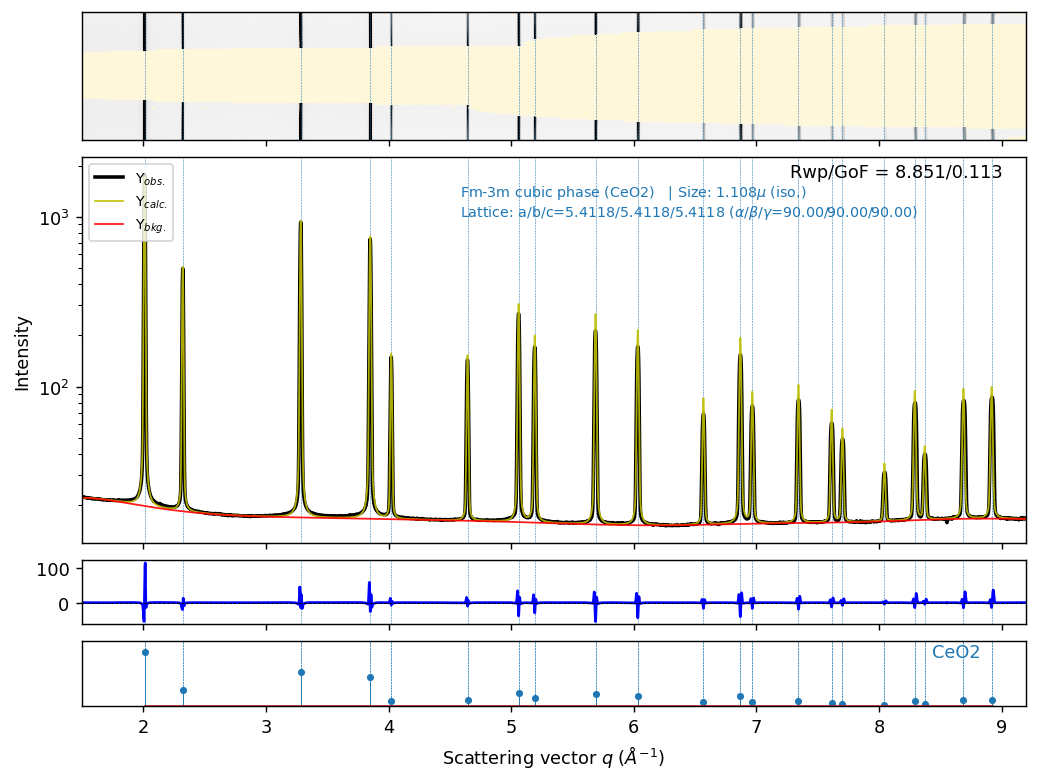

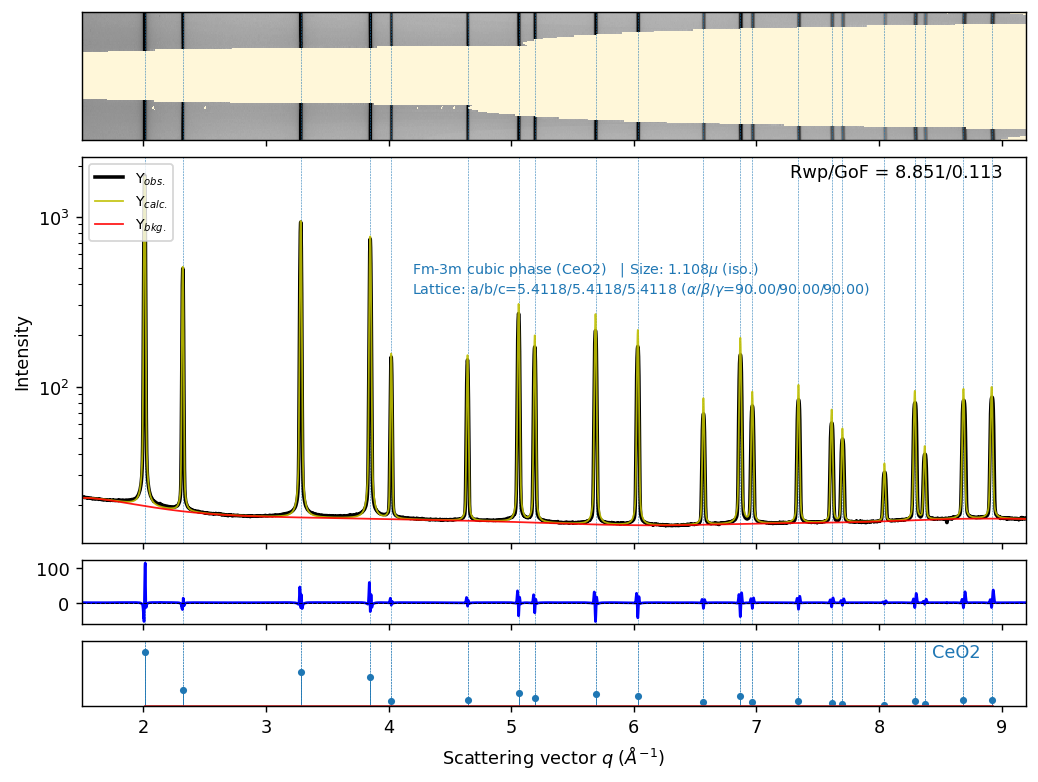

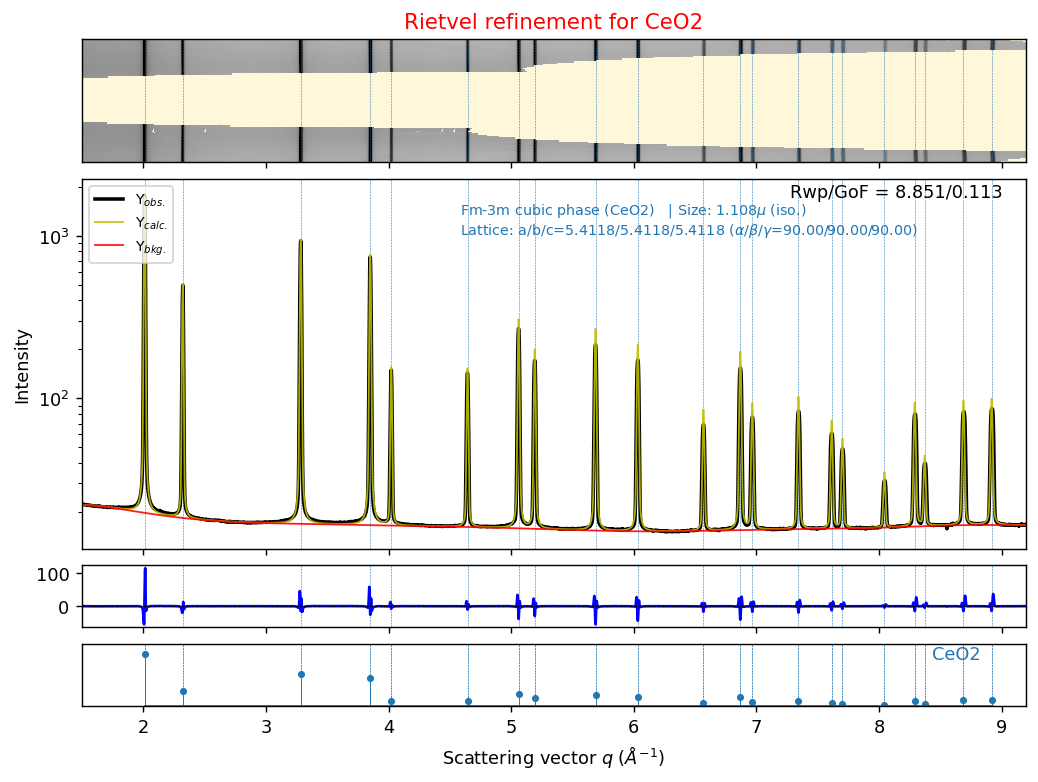

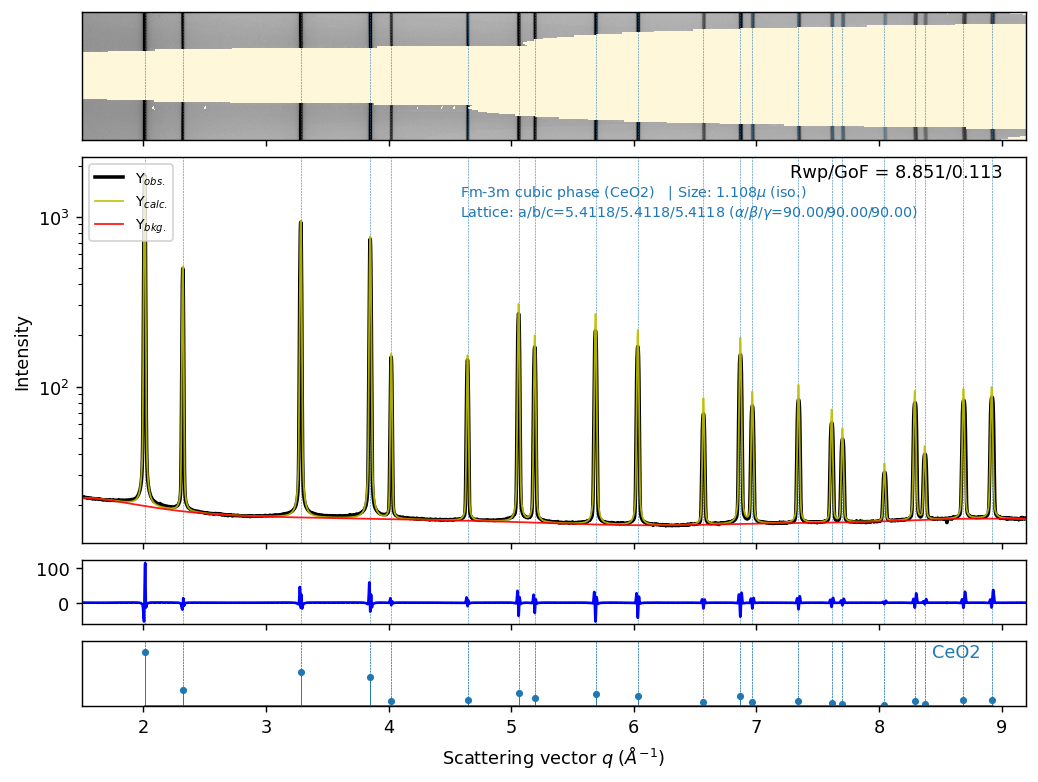

In [26]:
# The plot function here has more parameters. We can play with some of them here.

sample.plot(i1d_ylogscale=False) # Here we don't scale y-axis in log scale.
sample.plot(i2d_logscale=False) # Here we don't scale intensities in i2d in log scale.
sample.plot(site_str_x=0.5-0.15,site_str_y=0.8-0.2) # Here we move the info text inside the figure.
sample.plot(title='Rietvel refinement for CeO2') # Here we move the info text inside the figure.
sample.plot(export_fig_as='CeO2.pdf') # This creates a CeO2.pdf for high-resolution figures.
# See sample.plot? output for more details

# LaB6-CeO2-mix

Until now, we worked with pure LaB6 and CeO2 powders. Now we will work on a mix data of these materials.

Before that, we will read and integrate XRD of Kapton foil that was used during measurement of LaB6 and CeO2 powders.

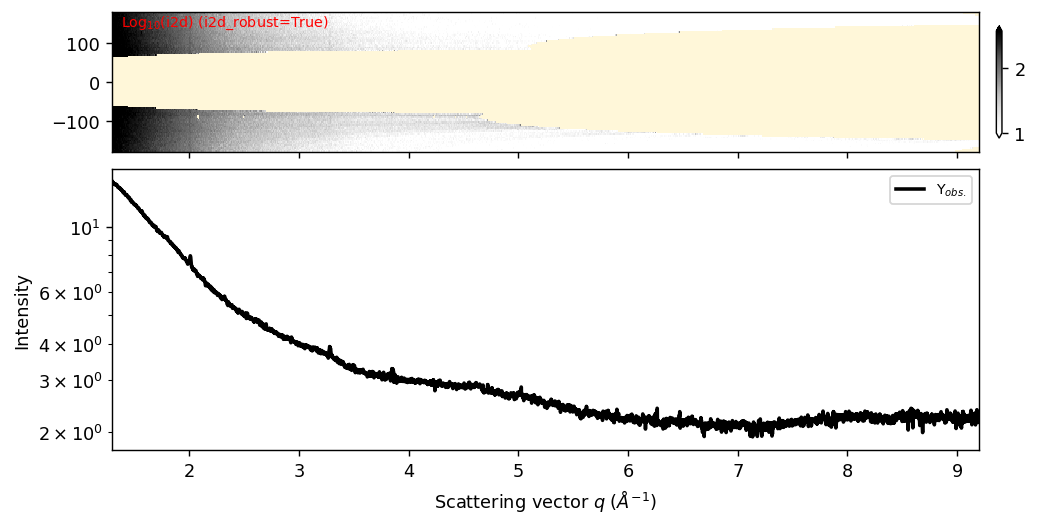

In [27]:
bkg = exrd()

bkg.load_xrd_data(
    from_tiff_file='Kapton/img.tiff',
    poni_file='geometry.poni',
    mask_file='mask.edf',
    radial_range=[1.3, 9.2]
    )

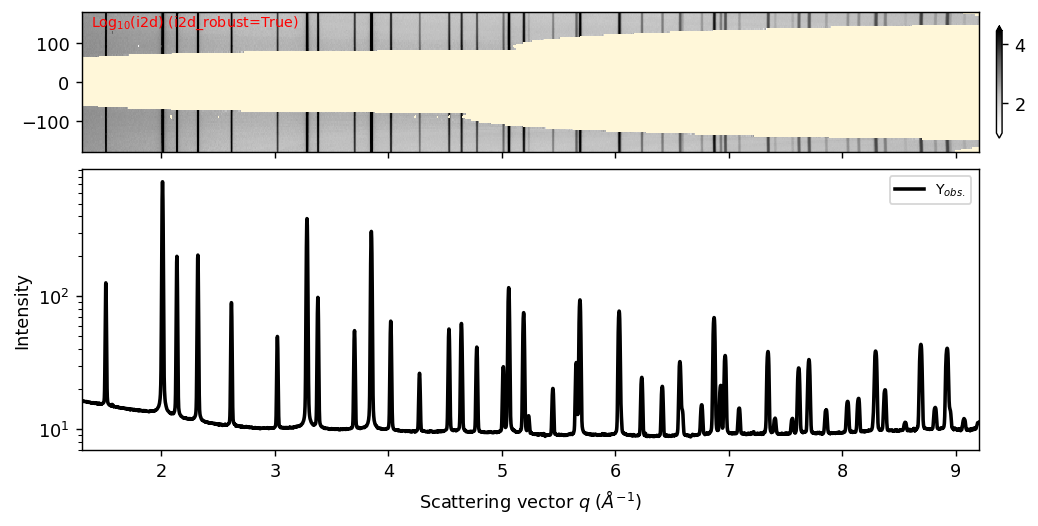

In [28]:
sample = exrd()

sample.load_xrd_data(
    from_tiff_file='LaB6_CeO2_mix/img.tiff',
    poni_file='geometry.poni',
    mask_file='mask.edf',
    radial_range=[1.3, 9.2]
    )

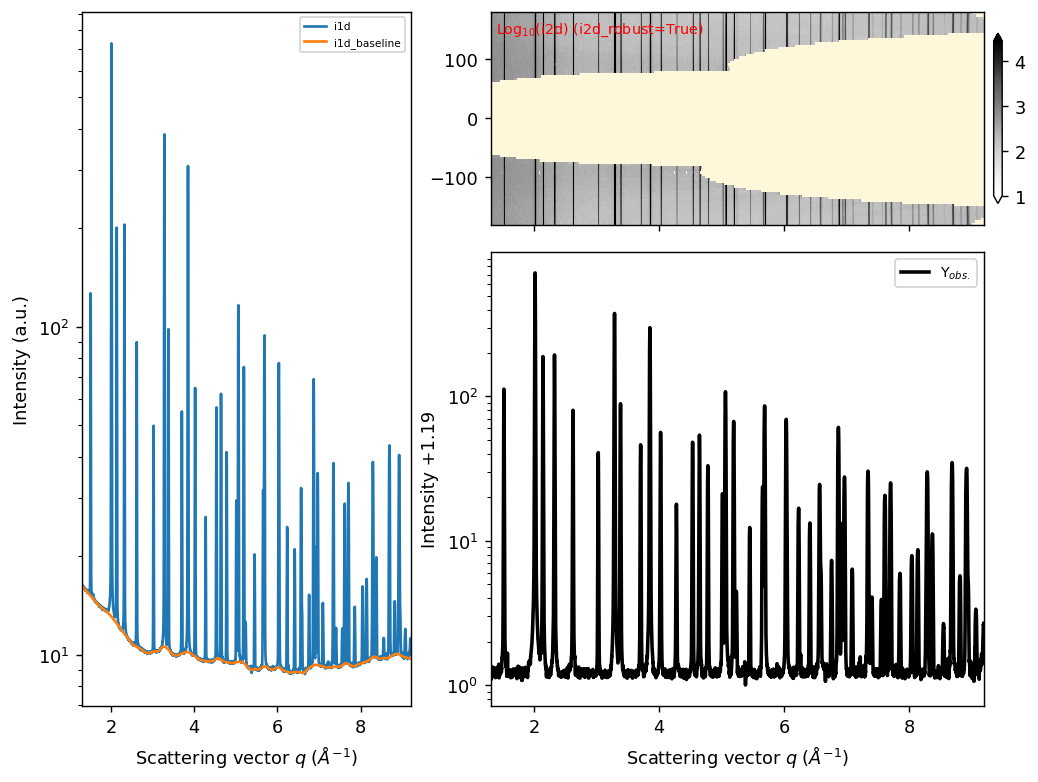

In [29]:
# Let's explore more details about get_baseline() feature of easyXRD.
#

sample.get_baseline()

# By default, it is using "iarpls (Improved Asymmetrically Reweighted Penalized Least Squares)"
# algorithm provided by pybaselines as in the note below:
# https://pybaselines.readthedocs.io/en/latest/algorithms/whittaker.html#iarpls-improved-asymmetrically-reweighted-penalized-least-squares

# It has a smoothing parameter, lam. Larger values will create smoother baselines. Default is 1e5.

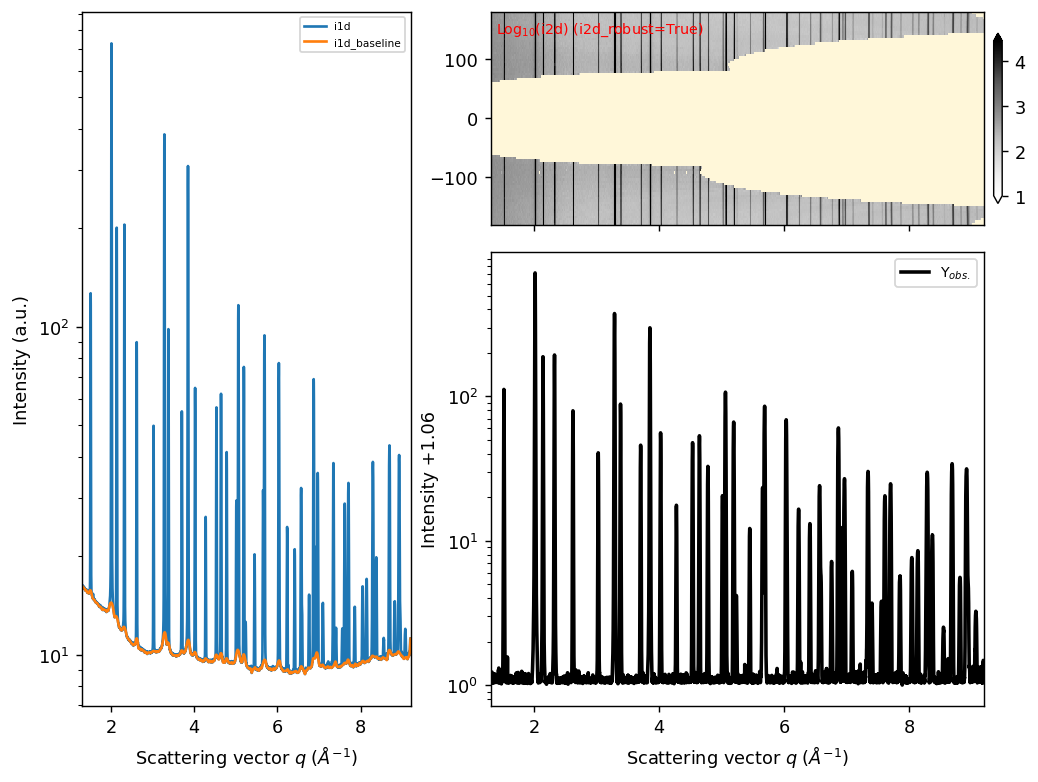

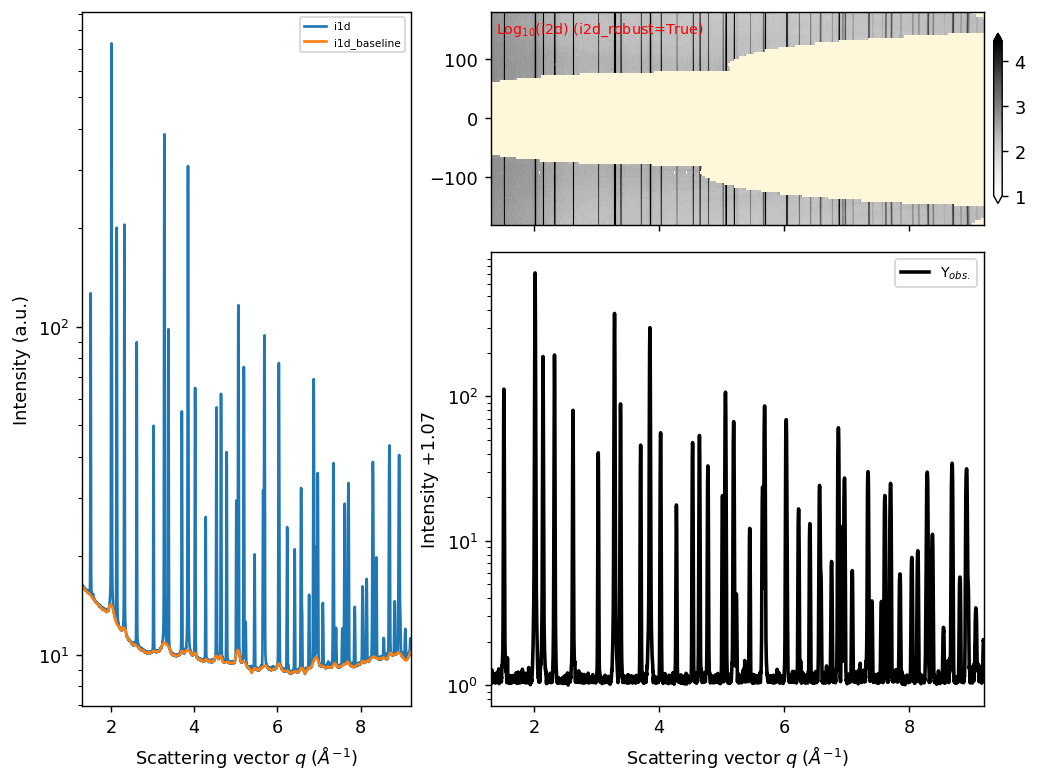

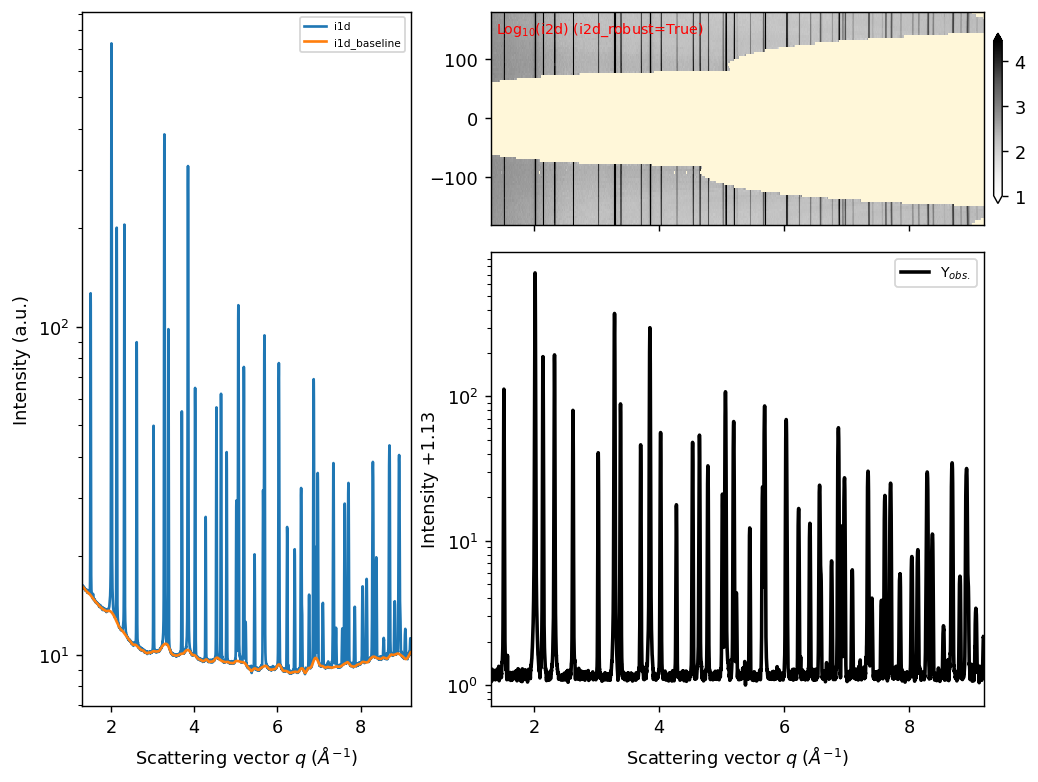

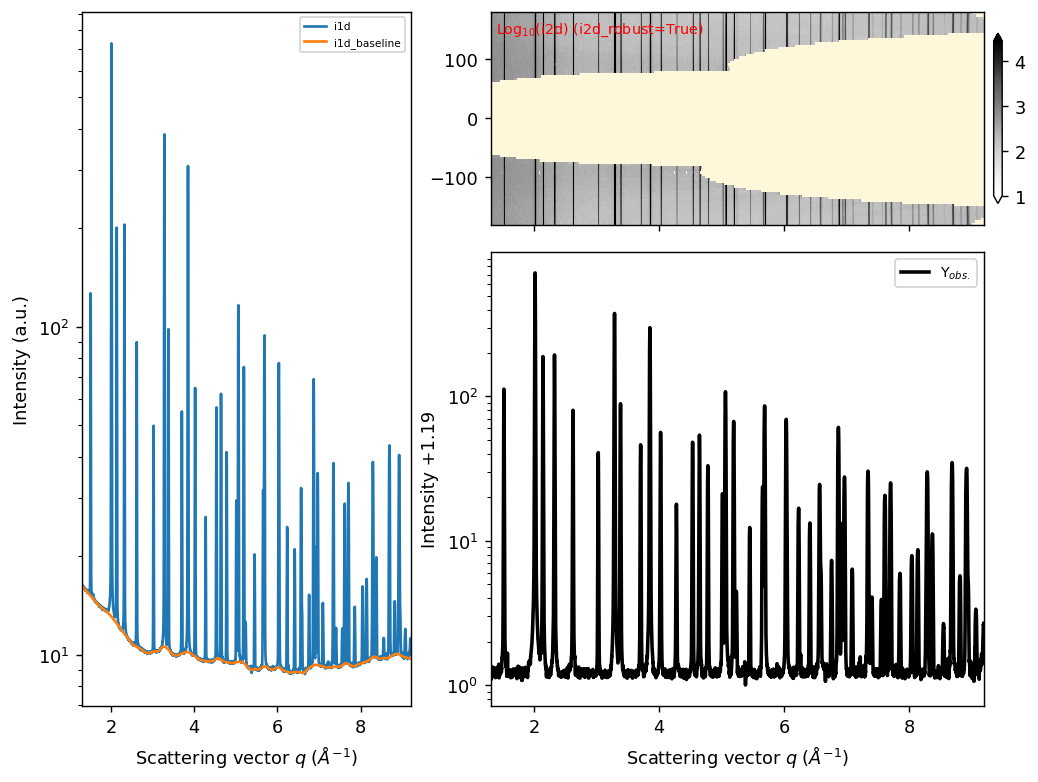

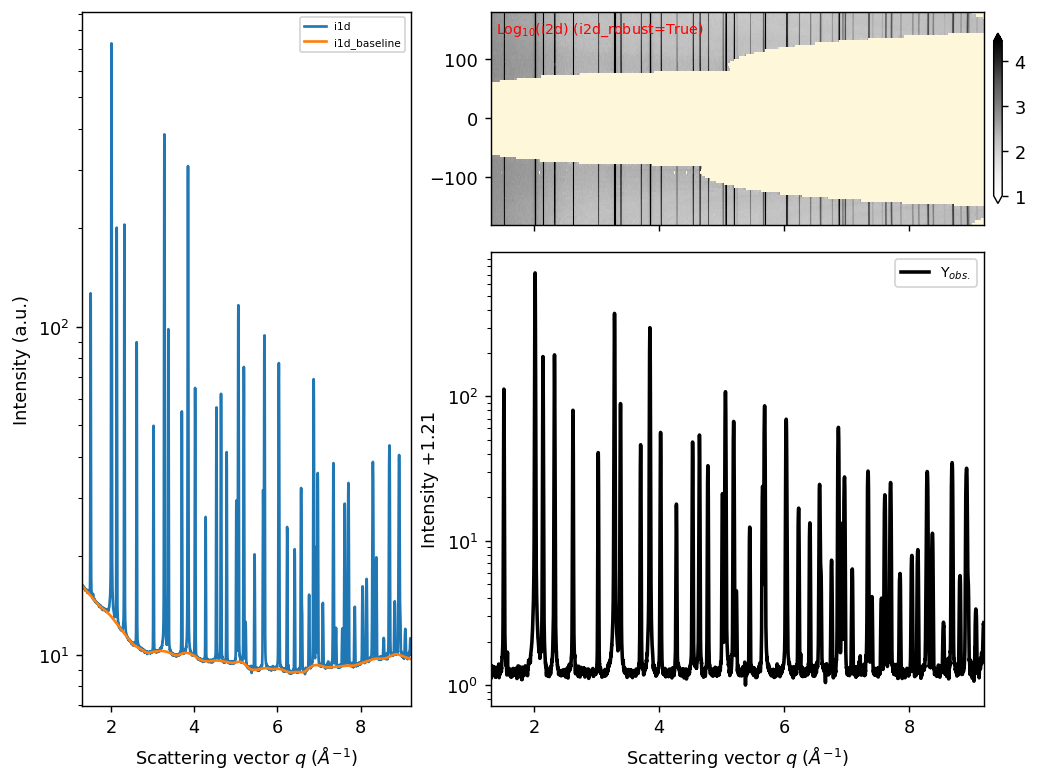

In [30]:
# We can easily vary iarpls_lam parameter from 1000 to 10000000 and see how it effects the estimated baseline.

sample.get_baseline(use_iarpls=True,iarpls_lam=1e2)
sample.get_baseline(use_iarpls=True,iarpls_lam=1e3)
sample.get_baseline(use_iarpls=True,iarpls_lam=1e4)
sample.get_baseline(use_iarpls=True,iarpls_lam=1e5)
sample.get_baseline(use_iarpls=True,iarpls_lam=1e6)

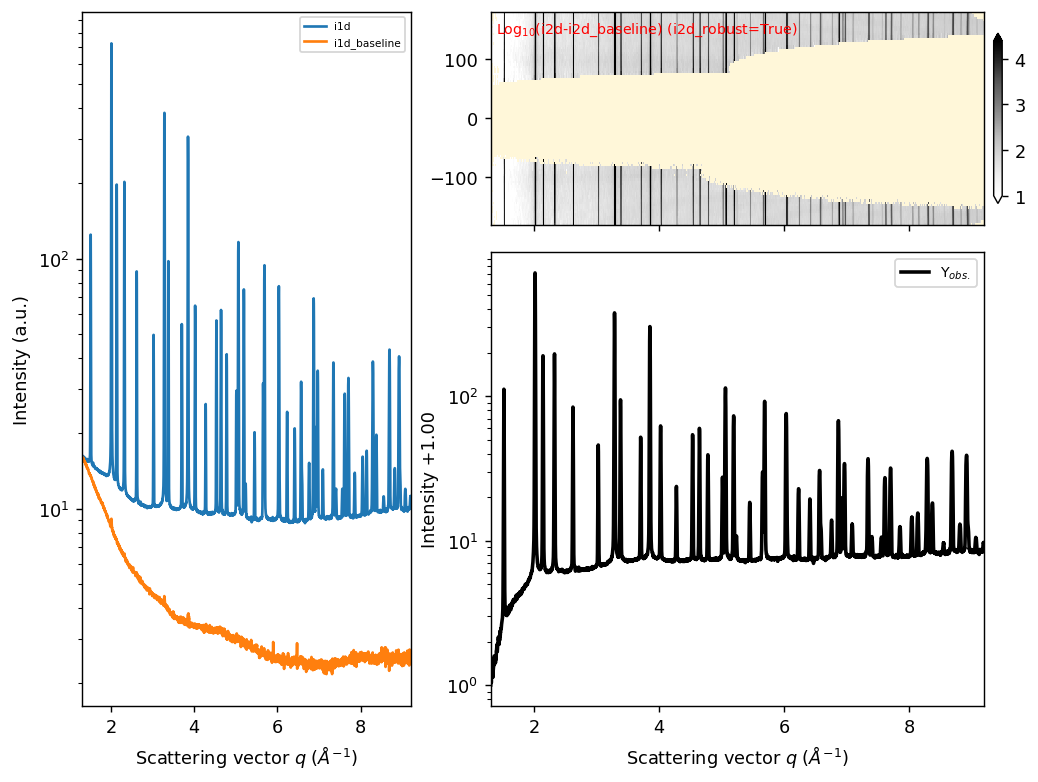

In [31]:
# Instead of estimating background with iarpls, we can use the Kapton data as shown below.
# The code automatically adjust the scaling parameter of input background until bbackground
# subtracted i1d doesn't have any negative values.

sample.get_baseline(input_bkg=bkg,use_iarpls=False)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

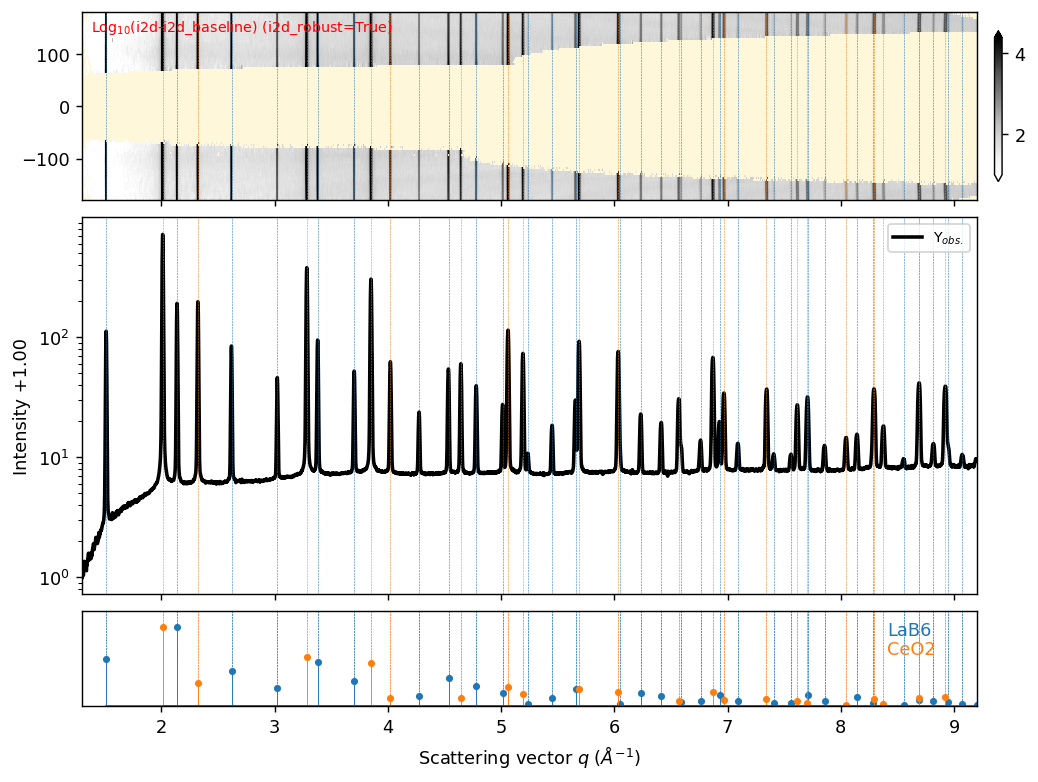

In [32]:
# Now we load phases from Materials Project

sample.load_phases(
    [
        {"mp_id": "mp-2680", "label": "LaB6",},
        {"mp_id": "mp-20194", "label": "CeO2", "scale": 0.99},
     ],
    plot=True,
    mp_rester_api_key=api_key,
    )

/root/g2full/GSAS-II/GSASII

 ⏩--1st refinement with LeBail is completed. Rwp/GoF is 38.838/0.632 

 ✅--Background with 5 coeffs is refined. Rwp/GoF is now 11.202/0.182 (was 38.838(-71.16%)/0.632(-71.15%✨))
 ✅--Background with 10 coeffs is refined. Rwp/GoF is now 11.149/0.181 (was 11.202(-0.48%)/0.182(-0.45%❗))
 ✅--Background with 15 coeffs is refined. Rwp/GoF is now 11.109/0.181 (was 11.149(-0.36%)/0.181(-0.33%❗))


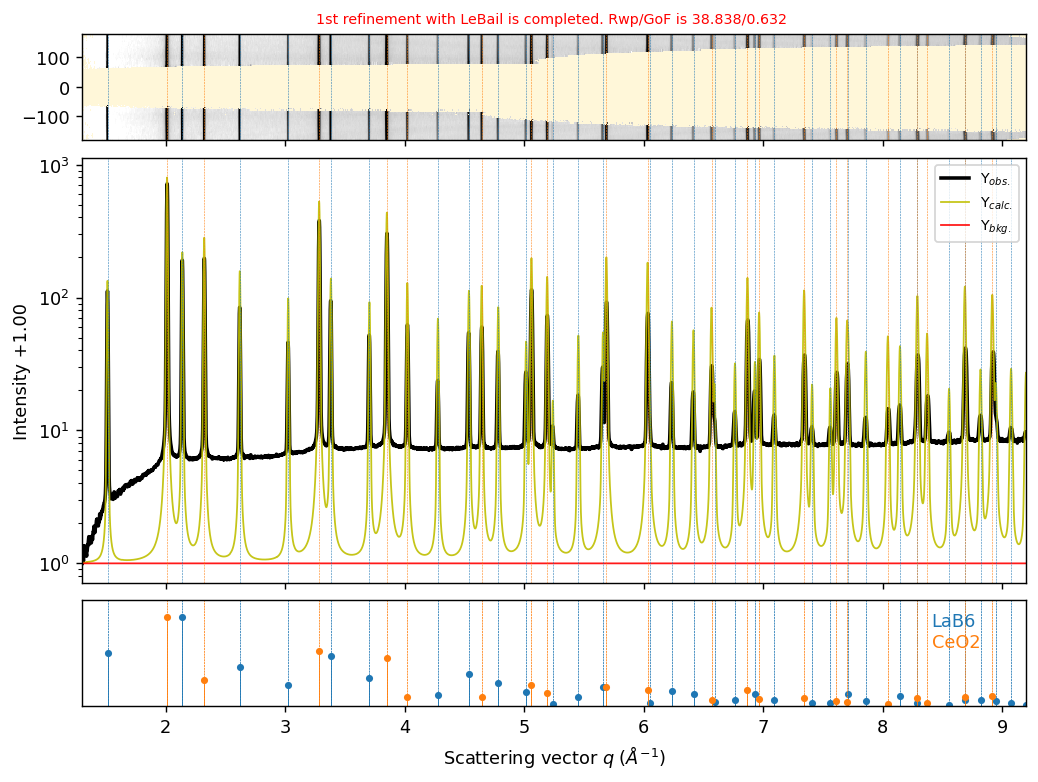

In [33]:
sample.setup_gsas2_refiner(plot=True, normalize=True, instprm_from_gpx='LaB6.gpx')
sample.refine_background(num_coeffs=5,plot=False)
sample.refine_background(num_coeffs=10,plot=False)
sample.refine_background(num_coeffs=15,plot=False)

 ✅--Cell parameters of all phases are refined. Rwp/GoF is now 7.085/0.115 (was 11.109(-36.23%)/0.181(-36.28%✨))


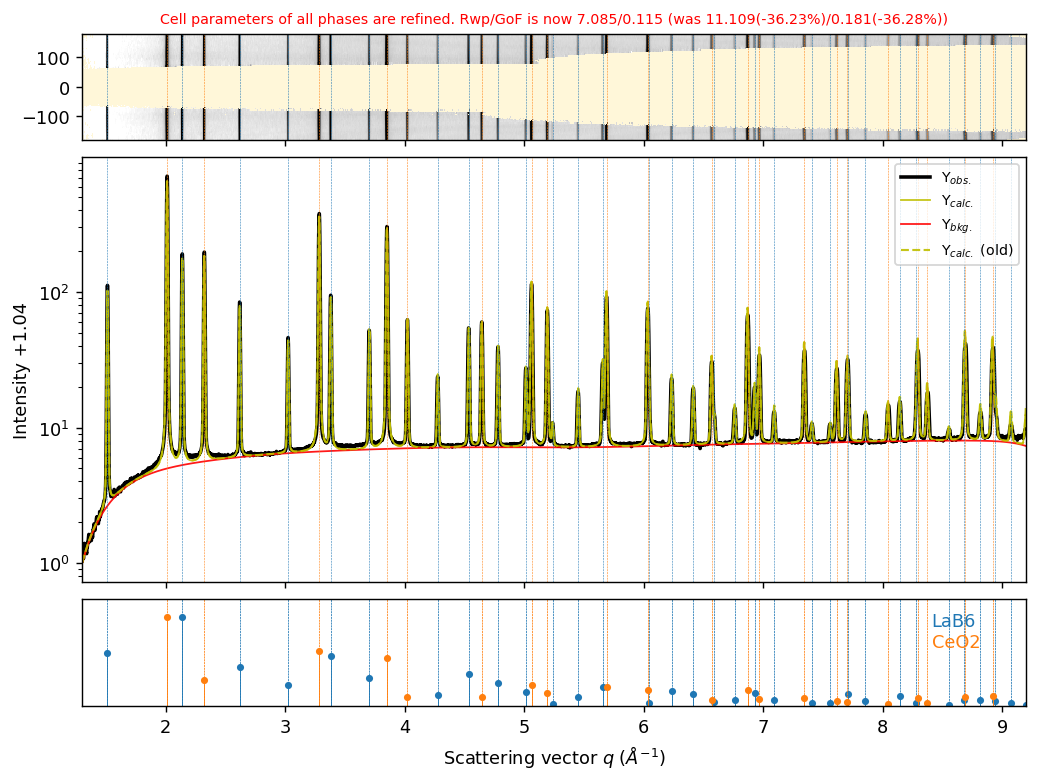

In [34]:
# We can refine cell parameters of LaB6 and CeO2 at the same time
sample.refine_cell_parameters(plot=True)

 ✅--Cell parameters of LaB6 phase are refined. Rwp/GoF is now 7.054/0.115 (was 7.085(-0.43%)/0.115(-0.44%❗))
 ✅--Cell parameters of CeO2 phase are refined. Rwp/GoF is now 7.068/0.115 (was 7.054(0.19%)/0.115(0.19%❗))


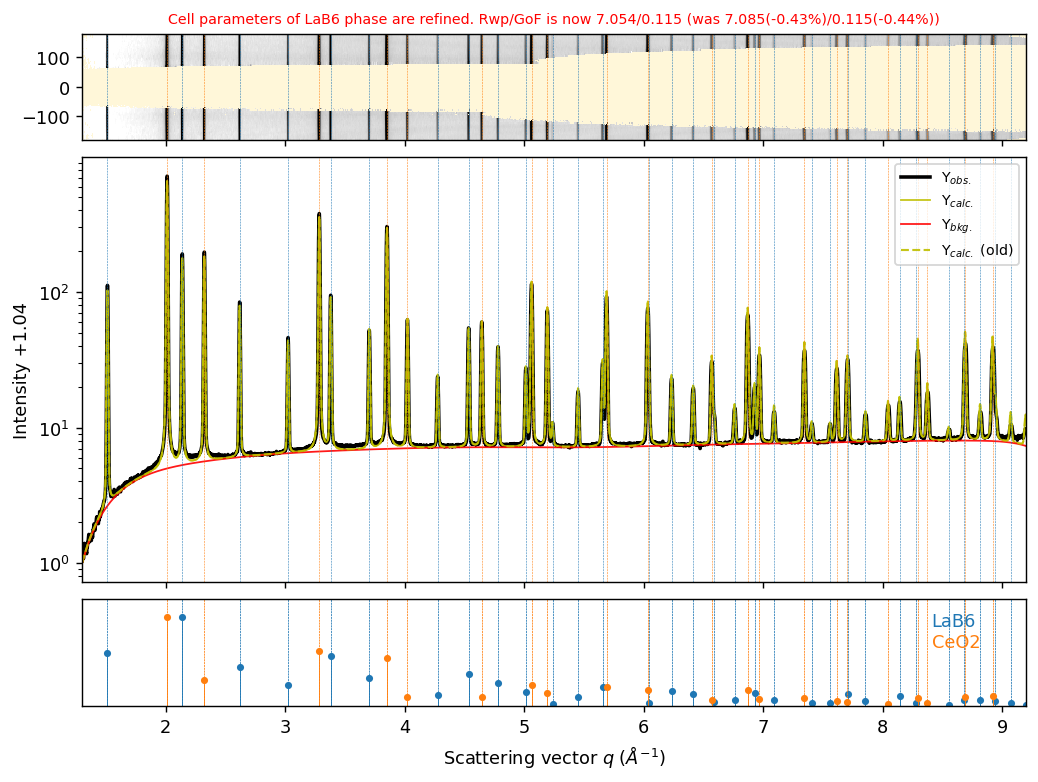

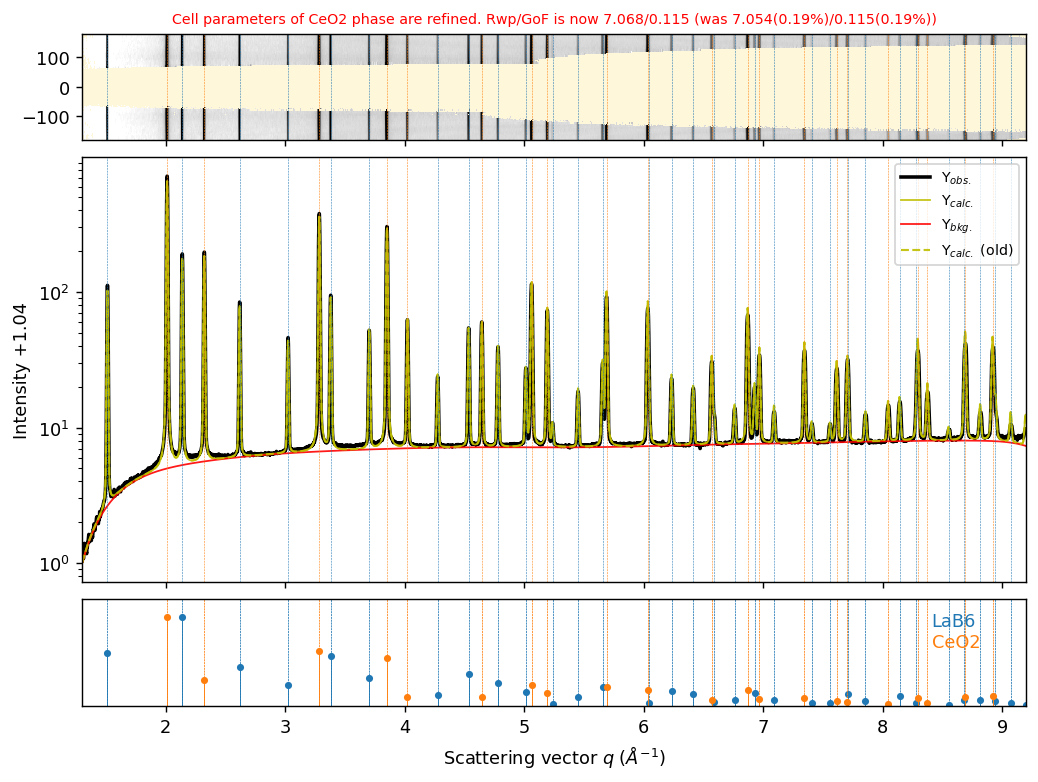

In [35]:
# or , they can be refined one-by-one
sample.refine_cell_parameters(plot=True,phase_ind=0)
sample.refine_cell_parameters(plot=True,phase_ind=1)


 ✅--After setting LeBail refinement to True, Rwp/GoF is now 10.756/0.175 (was 7.068(52.19%)/0.115(52.18%❗))


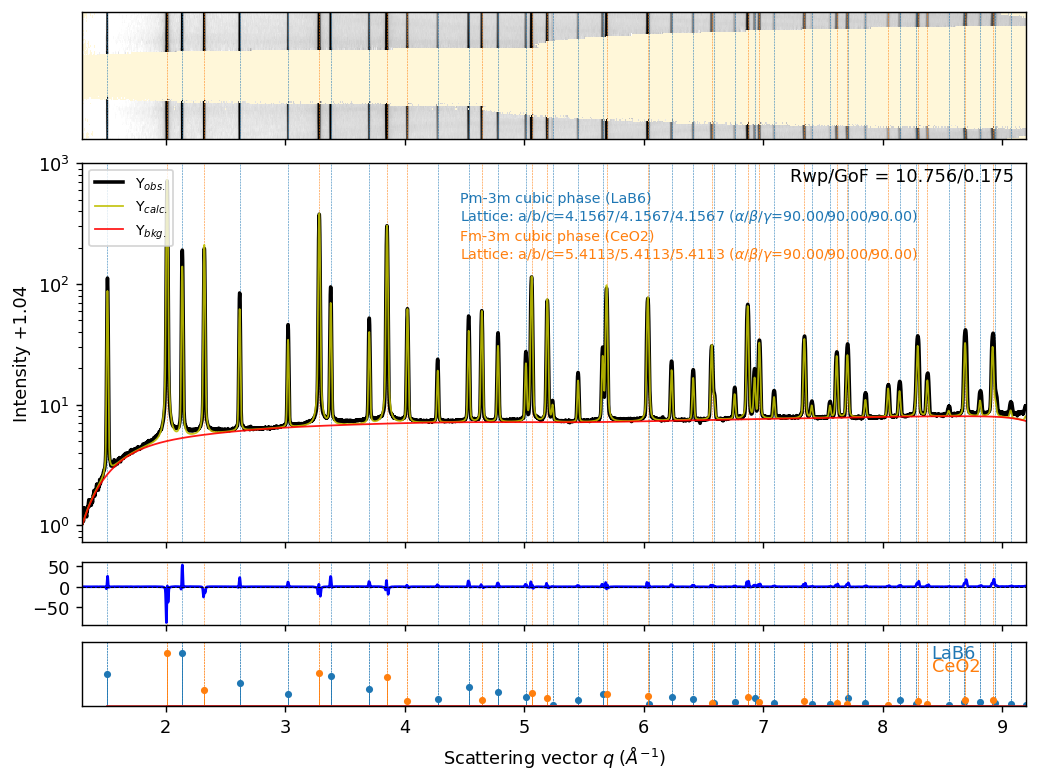

In [36]:
# Now we are enabling Rietveld type refinement.
sample.set_LeBail(to=False, refine=True, plot=False)
sample.plot()

 ✅--Phase fractions of all phases are refined. Rwp/GoF is now 9.182/0.149 (was 10.756(-14.64%)/0.175(-14.63%✨))


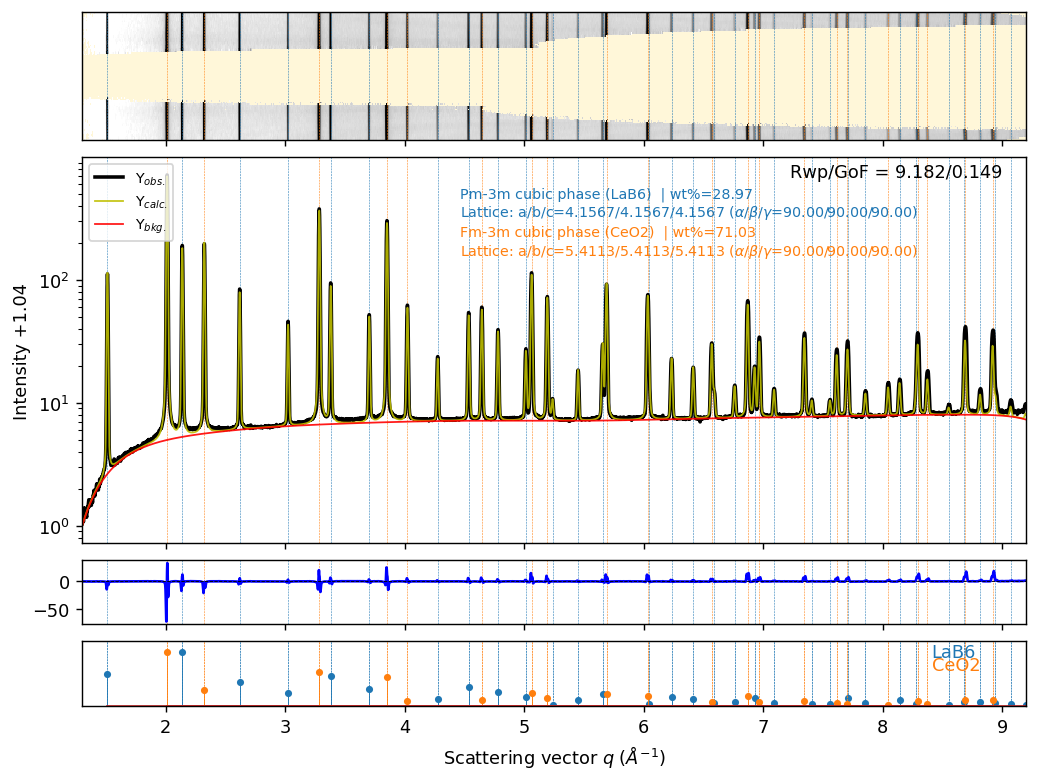

In [37]:
# For samples consisting of multiple phases, we need to refine phase fractions.
sample.refine_phase_fractions()
sample.plot(show_wt_fractions=True)

In [38]:
# Again we need to refine atom properties of CeO2 and LaB6 phases. Note phase_ind here.

sample.refine_site_property(phase_ind=0, site_ind=0,refinement_flags='U',plot=False) # This refines Uiso of La site
sample.refine_site_property(phase_ind=0, site_ind=1,refinement_flags='U',plot=False) # This refines Uiso of La site

sample.refine_site_property(phase_ind=1, site_ind=0,refinement_flags='U',plot=False) # This refines Uiso of Ce site
sample.refine_site_property(phase_ind=1, site_ind=1,refinement_flags='U',plot=False) # This refines Uiso of O site

 ✅--U property of La0 site of LaB6 phase is refined. Rwp/GoF is now 8.991/0.146 (was 9.182(-2.08%)/0.149(-2.08%))
 ✅--U property of B1 site of LaB6 phase is refined. Rwp/GoF is now 8.971/0.146 (was 8.991(-0.22%)/0.146(-0.22%❗))
 ✅--U property of Ce0 site of CeO2 phase is refined. Rwp/GoF is now 7.205/0.117 (was 8.971(-19.68%)/0.146(-19.68%✨))
 ✅--U property of O1 site of CeO2 phase is refined. Rwp/GoF is now 7.179/0.117 (was 7.205(-0.36%)/0.117(-0.36%❗))


 ✅--Background with 15 coeffs is refined. Rwp/GoF is now 7.100/0.116 (was 7.179(-1.10%)/0.117(-1.01%))
 ✅--Cell parameters of all phases are refined. Rwp/GoF is now 7.099/0.115 (was 7.100(-0.01%)/0.116(-0.10%❗))
 ✅--Phase fractions of all phases are refined. Rwp/GoF is now 7.055/0.115 (was 7.099(-0.62%)/0.115(-0.62%❗))


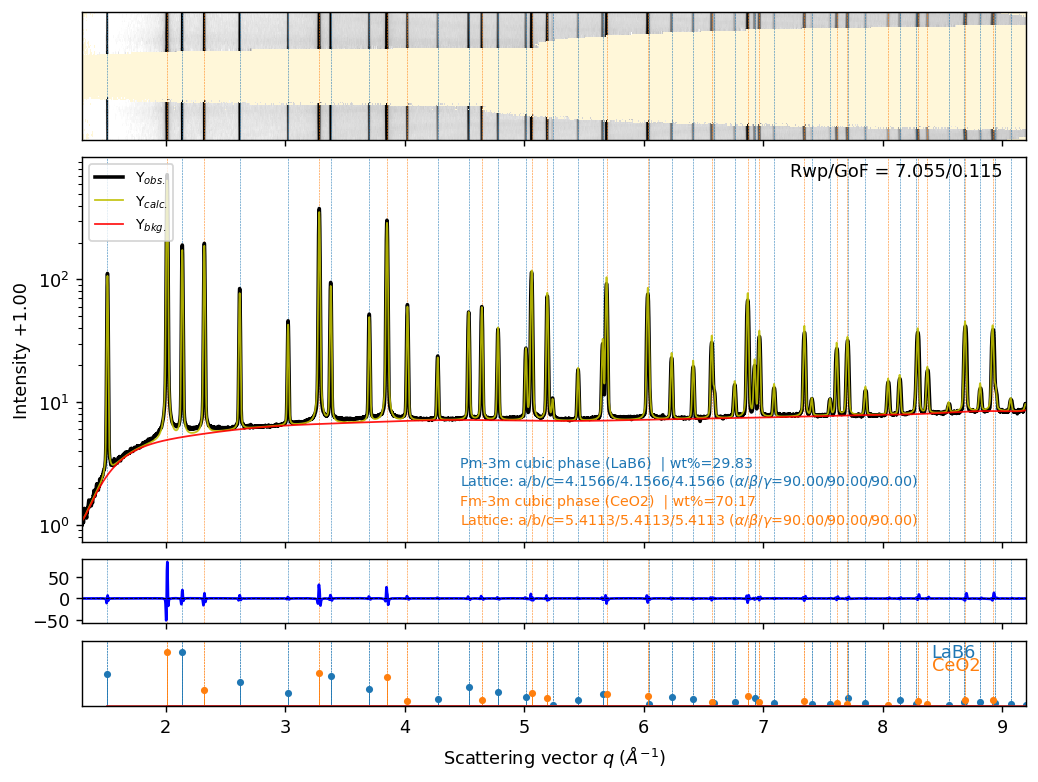

In [39]:
# It would be good to re-refine bakground, cell parameters, and wt fractions

sample.refine_background(num_coeffs=15,plot=False)
sample.refine_cell_parameters(plot=False)
sample.refine_phase_fractions(plot=False)

sample.plot(show_wt_fractions=True,site_str_y=0.1)